# <center> «Модель прогнозирования стоимости жилья для агентства недвижимости»

<img src=https://idei.club/uploads/posts/2022-03/1646444390_40-idei-club-p-dvukhetazhnii-dom-v-amerike-interer-krasiv-69.jpg>

In [3]:
#импорт библиотек
import pandas as pd, numpy as np, zipfile, re #для анализа и предобработки данных
import numpy as np #для матричных вычислений
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px #для визуализации
from array import * #для работы с массивами
import category_encoders as ce #для кодирования признаков

# Импортируем Scikit Learn библиотки
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler


Реализуем процесс разработки DS-проектов согласно методологии CRISP-DM.

Этапы модели CRISP-DM:
1. Анализ требований
2. Исследование данных
3. Подготовка данных
4. Моделирование
5. Оценка модели
6. Внедрение

### Анализ требований

Задание: разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

### Знакомство с данными

*Функции для обработки выбросов*

In [14]:
# Метод межквартильного размаха (методом Тьюки)
def outliers_iqr(data, feature):
    
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

# Поиск выбросов методом z-score (поиск по отклонению)
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [125]:
# Прочитаем данные с помощью библиотеки Pandas
data=pd.read_csv('data.csv', sep=',')

In [16]:
# Чтобы не переопределять переменную data и тем самым не повредить первоначальный DataFrame, создадим копию df с помощью метода copy()
df = data.copy()

In [17]:
# Выведите несколько первых (последних строк таблицы), чтобы убедиться в том, что ваши данные не повреждены. Ознакомьтесь с признаками и их структурой.
print(df.head(), df.tail(), sep='\n')

     status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7',

Данные не однордны, признаки 'homeFacts' и 'schools' представляют собой словари и содержат несколько отдельных сведений. Необходимо десериализовать содержимое этих признаков. Если имеются полезные данные, то необходимо из них создать новые признаки.

In [18]:
display(df.head())

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Каждый объект недвижимости описывается набором признаков:
1. 'status' - статус продажи
2. 'private pool’ и 'PrivatePool' - наличие частного бассейна,
3. 'propertyType' - тип недвижимости, поместья, свойства,
4. 'street' - адрес дома
5. 'baths' - количество ванных комнат
6. 'homeFacts' - сведения о строении дома, содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры
7. 'fireplace' - сведения о наличии камина (ов) в доме
8. 'city' - город
9. 'schools' - сведения о школах в районе
10. 'sqft' - площадь дома в футах
11. 'zipcode' - почтовый индекс
12. 'beds' - количество спален в доме
13. 'state' - государство/штаты
14. 'stories' - этажность недвижимости
15. 'mls-id' и 'MlsId' - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
16. 'target' - целевой признак, который необходимо спрогнозировать - цена недвижимости


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

### 2. Исследование данных

Цель этого шага — понять слабые и сильные стороны предоставленных данных, определить их достаточность, оценить взаимосвязи между признаками и предложить идеи, как их использовать.

Есть пропуски в данных необходимо уделить внимание этому вопросу.

In [20]:
# Статистическая информация по датасету
df.describe().round()


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [21]:
print('Количество строк: {}'.format(data.shape))

Количество строк: (377185, 18)


In [127]:
print(sns.__version__)

0.13.0


Перед моделирование нужно качественно подойти к подготовке данныех по кажому столбцу выполним отдельно с подробным описанием

### 3. Подготовка данных

In [22]:
# Найдем дубликаты с помощью метода duplicated() и удалим — с помощью метода drop_duplicates().
print('Дубликатов найдено: {}'.format(df.duplicated().sum()))
# Дубликатов найдено: 50
df.drop_duplicates(inplace = True)
print('Количесвто строк без дубликатов: {}'.format(df.shape))

Дубликатов найдено: 50
Количесвто строк без дубликатов: (377135, 18)


### Преобразуем каждый признак по отдельности

#### MLSID - Идентификатор MLS

In [23]:
# MlsId - уникальный идентификатор объекта недвижимости
# Найдем один и тот же объект недвижимсоти в разных записях, выполнив группировку по столбцам 'mls-id' и 'MlsId'
# Возьмем за ключевое значение цену объекта - 'target'
df['target'].groupby([df['mls-id'], df['MlsId']]).apply(list).reset_index()

,mls-id,MlsId,target


Возможных записей, которые могли бы дополнить недостающую информацию не найдены.
Можно выполнить объединение столбцов.

In [24]:
# Объединяем столбцы с информацией Multiple Listing Service - Служба множественного листинга
df['MlsId'] = df['MlsId'].fillna(df['mls-id']) # объединяем столбцы заменив пустые значения в первом из второго
df['MlsId'] = df['MlsId'].replace({'NO MLS': None, 'No MLS #': None }) # Заменяем отсутсвие ифномрации на None
print('Уникальных значений: {}'.format(df['MlsId'].nunique()))

Уникальных значений: 249010


In [25]:
print('Всего значений: {}'.format(df['MlsId'].count()))
print('Уникальных значений: {}'.format(df['MlsId'].nunique()))
print('Пропусков: {}'.format(df['MlsId'].isna().sum()))
df['MlsId'].unique()[:50]

Всего значений: 335167
Уникальных значений: 249010
Пропусков: 41968


array(['611019', '201916904', 'FR19221027', '14191809', '861745',
       'PAPH847006', 'S5026943', '10063506', '190988', '73968331',
       '3087630', '5741322', 'A10767242', '19221142', '65299510',
       '3182740', 'F10207914', '4975368', '95301365', 'A10622323',
       'SR19195113', '201909438', 'A10786027', '13624110', '6208631',
       'DCDC448770', 'A10787617', '33856933', 'A10782357', nan,
       '19-518208', 'T3159863', 'F10174710', 'A10775650', '1027438',
       '3554602', '533746', 'A10743020', 'T3204536', '14150656',
       'D6107075', '190057878', 'STRI1057289', 'A10739627', '2160520',
       'SR19267193', '10114247', '1310212', '5876037', '234684'],
      dtype=object)

Уникальных значений, как и ожидалось получилось много. Теперь можно избавиться от дублирующих записей, чтобы очистить датасет

In [26]:
df1 = df[df.MlsId.isnull() == False] # Фильтруем: не пустые значения
df2 = df[df.MlsId.isnull() == True] # Фильтруем: пропущенные значения 

In [27]:
print('Всего значений: {}'.format(df1['MlsId'].count()))
print('Уникальных значений: {}'.format(df1['MlsId'].nunique()))
print('Пропусков: {}'.format(df1['MlsId'].isna().sum()))
df1['MlsId'].unique()[:50]

Всего значений: 335167
Уникальных значений: 249010
Пропусков: 0


array(['611019', '201916904', 'FR19221027', '14191809', '861745',
       'PAPH847006', 'S5026943', '10063506', '190988', '73968331',
       '3087630', '5741322', 'A10767242', '19221142', '65299510',
       '3182740', 'F10207914', '4975368', '95301365', 'A10622323',
       'SR19195113', '201909438', 'A10786027', '13624110', '6208631',
       'DCDC448770', 'A10787617', '33856933', 'A10782357', '19-518208',
       'T3159863', 'F10174710', 'A10775650', '1027438', '3554602',
       '533746', 'A10743020', 'T3204536', '14150656', 'D6107075',
       '190057878', 'STRI1057289', 'A10739627', '2160520', 'SR19267193',
       '10114247', '1310212', '5876037', '234684', '3120965'],
      dtype=object)

In [28]:
df1.drop_duplicates(subset = 'MlsId', inplace = True)

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/4035173818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(subset = 'MlsId', inplace = True)


In [29]:
print('Всего значений: {}'.format(df1['MlsId'].count()))
print('Уникальных значений: {}'.format(df1['MlsId'].nunique()))
print('Пропусков: {}'.format(df1['MlsId'].isna().sum()))
df1['MlsId'].unique()[:50]

Всего значений: 249010
Уникальных значений: 249010
Пропусков: 0


array(['611019', '201916904', 'FR19221027', '14191809', '861745',
       'PAPH847006', 'S5026943', '10063506', '190988', '73968331',
       '3087630', '5741322', 'A10767242', '19221142', '65299510',
       '3182740', 'F10207914', '4975368', '95301365', 'A10622323',
       'SR19195113', '201909438', 'A10786027', '13624110', '6208631',
       'DCDC448770', 'A10787617', '33856933', 'A10782357', '19-518208',
       'T3159863', 'F10174710', 'A10775650', '1027438', '3554602',
       '533746', 'A10743020', 'T3204536', '14150656', 'D6107075',
       '190057878', 'STRI1057289', 'A10739627', '2160520', 'SR19267193',
       '10114247', '1310212', '5876037', '234684', '3120965'],
      dtype=object)

In [30]:
print('Всего значений: {}'.format(df2['MlsId'].count()))
print('Уникальных значений: {}'.format(df2['MlsId'].nunique()))
print('Пропусков: {}'.format(df2['MlsId'].isna().sum()))
df2['MlsId'].unique()[:50]

Всего значений: 0
Уникальных значений: 0
Пропусков: 41968


array([nan, None], dtype=object)

In [31]:
#  Объедимим датасеты без дубликатов и с пропущенными значениями в один (так как мы не можем идентифицировать их как уникальные или дублирующие)
df = pd.concat([df1, df2], axis = 0)
df.reset_index(inplace = True, drop = True)

In [32]:
# Столбцы с MlsId нам больше не нужны, удаляем
df.drop(['MlsId','mls-id'],axis=1,inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290978 entries, 0 to 290977
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        262082 non-null  object
 1   private pool  3407 non-null    object
 2   propertyType  267091 non-null  object
 3   street        290977 non-null  object
 4   baths         211453 non-null  object
 5   homeFacts     290978 non-null  object
 6   fireplace     76911 non-null   object
 7   city          290952 non-null  object
 8   schools       290978 non-null  object
 9   sqft          257969 non-null  object
 10  zipcode       290978 non-null  object
 11  beds          223613 non-null  object
 12  state         290978 non-null  object
 13  stories       174547 non-null  object
 14  PrivatePool   31323 non-null   object
 15  target        288506 non-null  object
dtypes: object(16)
memory usage: 35.5+ MB


#### PrivatePool - Бассейны

In [34]:
# Объединяем столбцы с информацией о наличии собственного бассена
df['PrivatePool'] = df['PrivatePool'].fillna(df['private pool']) # объединяем столбцы
df['PrivatePool'] = df['PrivatePool'].replace({'Yes': 'yes'}) # заменяем написание с большой буквы на малое, там где нписано с большой

In [35]:
df.drop(['private pool'],axis=1,inplace=True) # удалим столбец 'private pool'

In [36]:
# Закодируем наличие бассена 1 и его отсутствие 0
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: 1 if (x == 'yes') | (x == 1) else 0) 
print('Уникальных значений: {}'.format(df['PrivatePool'].nunique()))
df['PrivatePool'].value_counts()

Уникальных значений: 2


PrivatePool
0    256248
1     34730
Name: count, dtype: int64

#### baths - Ванные комнаты 

In [37]:
# Очищаем от текста и округляем до целого числа признак кол-во ванных комнат
df["baths"] = df["baths"].str.replace(r"[^\d\.]", "", regex=True) # удаляем текст
df['baths'] = np.floor(pd.to_numeric(df['baths'], errors='coerce')).astype('Int64') # переводим в числовой формат 

In [38]:
df['baths'].value_counts()

baths
2            92912
3            56243
4            21060
1            14533
5             7393
             ...  
43               1
3122             1
116116116        1
35               1
76               1
Name: count, Length: 65, dtype: Int64

In [39]:
# Списко с уникальными значениями кол-ва ванных комнат
value_list = pd.unique(df['baths'])
print(value_list)

<IntegerArray>
[        3,         2,         8,      <NA>,      1750,         4,         5,
      1000,         7,         1,         6,      2500,      4000,      2000,
      3000,         0,      1500,      1250,         9,      2250,        12,
      3500,      2750,       750,        10,        19,        18,        11,
      5000,        16,        13,        14,        17,      7500,        20,
        40,     10101,        24,        22,        32,        27,        26,
        15,        35,        29, 116116116,        21,      3122,        43,
        34,      1111,        55,        25,        44,        23,        41,
        36,        30,        28,        64,        39,        42,        60,
        68,       241,        76]
Length: 66, dtype: Int64


In [40]:
# количесвто ванных комнат
count_baths = df.groupby(['baths'])['baths'].count()
count_baths

baths
0             3099
1            14533
2            92912
3            56243
4            21060
             ...  
4000           185
5000           145
7500             8
10101            1
116116116        1
Name: baths, Length: 65, dtype: int64

<Axes: xlabel='baths'>

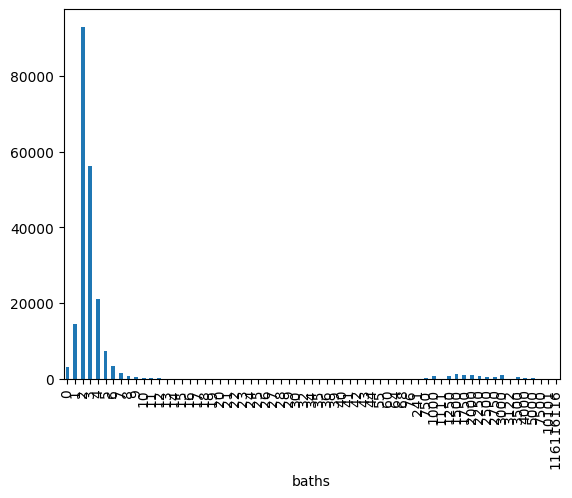

In [41]:
# количество ванных комнат на гистрограмме
groups = df.groupby(['baths'])['baths'].count()
groups.plot.bar()

In [42]:
# Приводим выбросы к медианному значению (возьмем, исходя из графика, выбросами значения больше '9')
median = df['baths'].median()
std = 9
outliers = (df['baths'] - median).abs() > std
df["baths"][outliers] = np.nan
df['baths'].fillna(median, inplace=True)

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/3272147663.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/3272147663.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


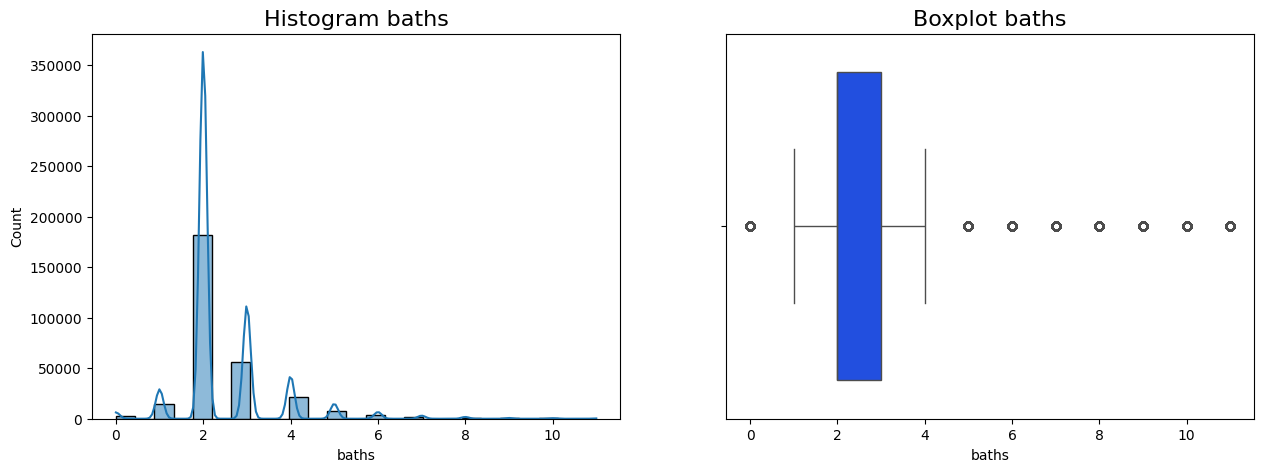

In [43]:
# Гисторграмма и коробчатая диаграмма распределения
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='baths',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram baths', fontsize=16);
sns.boxplot(
    data=df,
    x='baths',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot baths', fontsize=16);

In [44]:
outliers, cleaned = outliers_iqr(df, 'baths')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 16940
Результирующее число записей: 274038


Согласно классическому методу Тьюки, под выбросы у нас попали 16940 записи в таблице. Давайте построим гистограмму и коробчатую диаграмму на новых данных cleaned:

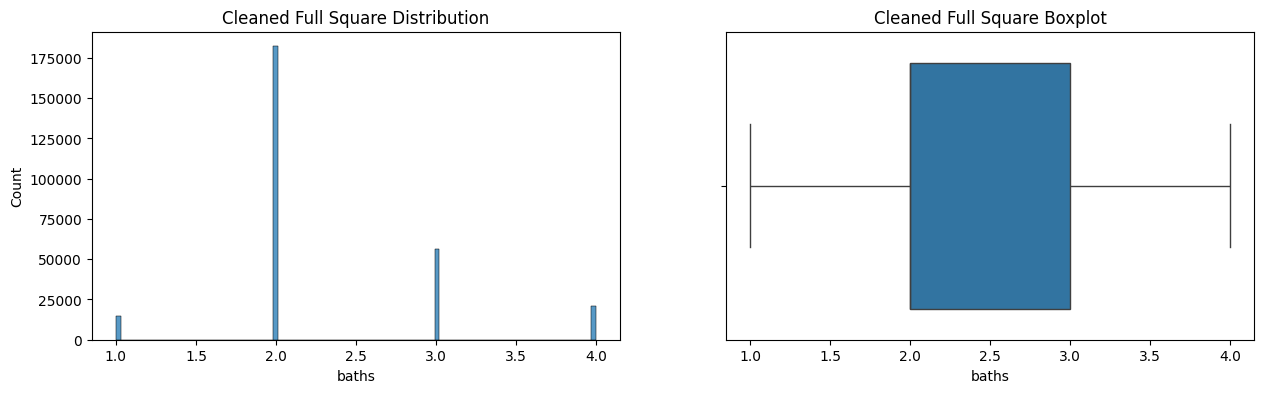

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='baths', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='baths', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

Так как речь идем о домах, наличие от 1 до 4 ванн вполне приемлемо и данные можно считать очищенными от выбросов по данному признаку.

In [46]:
# Переопределяем df на очищенные даныне по признаку baths
df = cleaned.copy()

 ### Словарь homeFacts - Информация об объекте недвижимости

In [47]:
print('Уникальных значений: {}'.format(df['homeFacts'].nunique()))
print('Пропусков: {}'.format(df['homeFacts'].isna().sum()))

Уникальных значений: 229083
Пропусков: 0


In [48]:
# Посмотрим на пример значения под индексом 0
df['homeFacts'][0]


"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

В столбце типом данных является строка, в которой закодирован словарь. Применим функцию eval для раскодировки словаря.

In [49]:
# Создадим новый столбец содержащий словарь для последующего выделения из него признаков
df['homeFacts_new'] = df['homeFacts'].apply(eval)

In [50]:
print('Тип значени до обработк: {}'.format(type(df['homeFacts'][0])))
print('Тип значени после обработки: {}'.format(type(df['homeFacts_new'][0])))
df['homeFacts_new'][0]

Тип значени до обработк: <class 'str'>
Тип значени после обработки: <class 'dict'>


{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

#### year_built - Дата постройки

In [51]:
# Извлечем из словаря год постройки дома и создадим новый признак 'year_built'
df['year_built'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [52]:
print('Уникальных значений: {}'.format(df['year_built'].nunique()))
print('Пропусков: {}'.format(df['year_built'].isna().sum()))
df['year_built'].unique()

Уникальных значений: 227
Пропусков: 2283


array(['2019', '1961', '', '1920', '2006', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1994', '1923', '1960', '1977', '1972', '1963', '1981',
       '1949', '1930', '1991', '1958', '2018', '1983', '1928', '1998',
       '1997', '1974', '1940', '1973', '1968', '1999', '1918', '2007',
       '1984', '1946', '2003', '2000', '2004', '2002', '1952', '2017',
       '1947', '1957', '1978', '1956', '1967', '1969', '1975', '1988',
       '1950', '1959', '2012', '1924', '1966', '2005', '1992', '2001',
       '1995', '2010', '1955', '1971', '1909', '1953', '1993', '1990',
       '1980', '1985', '1915', '1951', '1907', '1885', '1927', '1929',
       None, '1922', '1906', '1945', '1979', '2009', '1962', '1913',
       '2011', '1897', '1987', '2020', '1926', '1964', '1941', '1939',
       '1910', '2013', '1986', 'No Data', '1943', '1935', '1925', '1890',
       '1895', '1911', '1948', '1942', '1916', '1931', '1944', '1914',
 

In [53]:
# Удалим вручную ошибки ввода данных (выбросы)
# Здания, например, могут быть еще не построены возьмем 2026 верхней границей и 1500 нижней
df = df.drop(df[(df['year_built'] > '2026') | (df['year_built'] < '1500')].index)
df.reset_index(inplace = True, drop = True)
# Заменим пропуски и 'No Data' на none значение
df['year_built'] = df['year_built'].apply(lambda x: None if (x == '') | (x == 'No Data') else x)
# Переведем в int
df['year_built'] = df['year_built'].apply(lambda x: int(x) if x != None else x)

In [54]:
# Заполним пропуска медианными значением, округлённым до целого.
df['year_built'] = df['year_built'].fillna(round(df.year_built.median()))


In [55]:
df['year_built'].unique()

array([2019., 1961., 1920., 2006., 1976., 1970., 1965., 2015., 1996.,
       1982., 1905., 2008., 1899., 2016., 1954., 1989., 2014., 1994.,
       1923., 1960., 1977., 1972., 1963., 1981., 1949., 1930., 1991.,
       1958., 2018., 1983., 1928., 1998., 1997., 1974., 1940., 1973.,
       1968., 1999., 1918., 2007., 1984., 1946., 2003., 2000., 2004.,
       2002., 1952., 2017., 1947., 1957., 1978., 1956., 1967., 1969.,
       1975., 1988., 1950., 1959., 2012., 1924., 1966., 2005., 1992.,
       2001., 1995., 2010., 1955., 1971., 1909., 1953., 1993., 1990.,
       1980., 1985., 1915., 1951., 1907., 1885., 1927., 1929., 1922.,
       1906., 1945., 1979., 2009., 1962., 1913., 2011., 1897., 1987.,
       2020., 1926., 1964., 1941., 1939., 1910., 2013., 1986., 1943.,
       1935., 1925., 1890., 1895., 1911., 1948., 1942., 1916., 1931.,
       1944., 1914., 1937., 1912., 1938., 1921., 1900., 1860., 1901.,
       1936., 1861., 1898., 1908., 1865., 1917., 1934., 1880., 1700.,
       1904., 1932.,

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/196596041.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/196596041.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


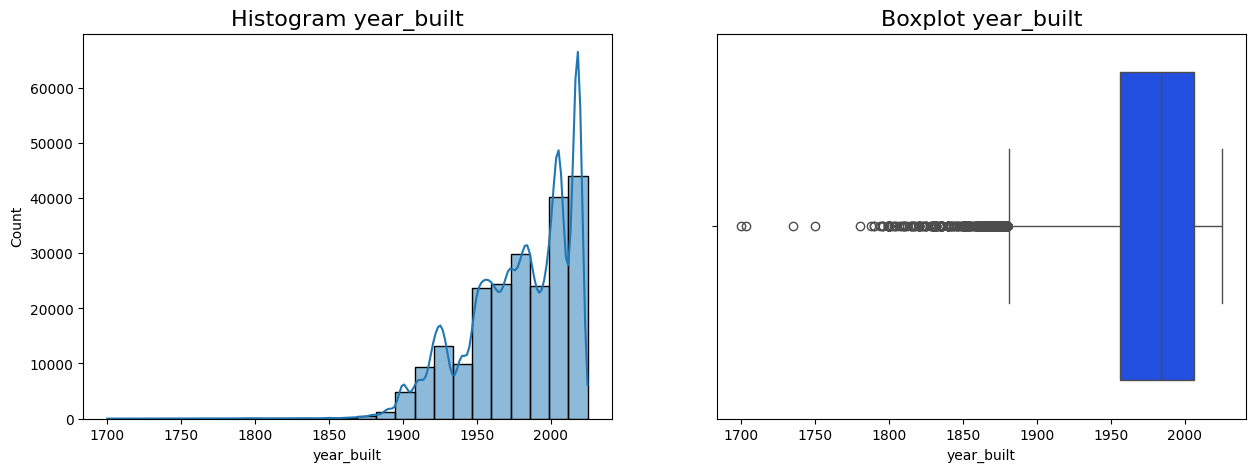

In [56]:
# Гисторграмма и коробчатая диаграмма распределения
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='year_built',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram year_built', fontsize=16);
sns.boxplot(
    data=df,
    x='year_built',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot year_built', fontsize=16);

In [57]:
outliers, cleaned = outliers_iqr(df, 'year_built')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 841
Результирующее число записей: 224407


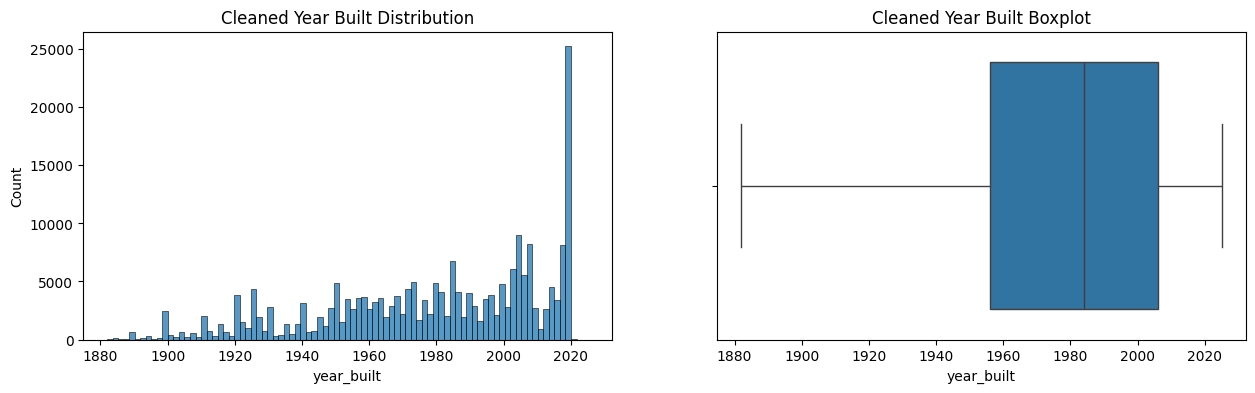

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='year_built', ax=axes[0]);
histplot.set_title('Cleaned Year Built Distribution');
boxplot = sns.boxplot(data=cleaned, x='year_built', ax=axes[1]);
boxplot.set_title('Cleaned Year Built Boxplot');

Распределения выглядит нормально с естественным смещением к более новым домам

In [59]:
# Переопределяем df на очищенные даныне по признаку year_built
df = cleaned.copy()

#### remodeled_year - Дата реконструкции

In [60]:
# Извлечём из словаря год реконструкции дома и создадим еще один признак remodeled_year.
df['remodeled_year'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [61]:
print('Уникальных значений: {}'.format(df['remodeled_year'].nunique()))
print('Пропусков: {}'.format(df['remodeled_year'].isna().sum()))
df['remodeled_year'].unique()

Уникальных значений: 141
Пропусков: 17632


array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2000', '1994', '1983', '2003', '1965', '1968', '1993',
       '1999', '2008', '2010', '2004', '2002', '1952', '1978', '2014',
       '1975', '1971', '1947', '1957', '1973', '1970', '2016', '1950',
       '1989', '1998', '1955', '1991', '1980', '2017', '1986', '2005',
       '2001', '1979', '1984', '1918', '1977', '1962', '1956', '2013',
       '1960', '2011', '1981', '1969', '1987', '1958', '1992', '1943',
       '1925', '1961', '1948', '1931', '1966', '2012', '1976', '1974',
       '1935', '1940', '2018', '1916', '1914', '1963', '1985', '1951',
       '1964', '1990', '1942', '1927', '1946', '1944', '1901', '1910',
       '1945', '1920', '1938', '1959', '1936', '0', '1939', '1915',
       '1928', '1923', '1941', '1929', '1899', '1934', '1953', '1926',
       '1937', '1912', '1917', '1906', '1932', '1921', '1924', '1911',
       

 Предположим, что пустая строка ' ', '0' и пропуски означают то, что реконструкция дома не проводилась. Заменим на значения None.
 

In [62]:
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: None if (x == '') | (x == '0') else x)

In [63]:
# Закодируем значения. 1 - если проводилась реконструкция и 0 - если не проводилась
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: 0 if (x == None) | (x == '0') else 1)
df.remodeled_year.value_counts()

remodeled_year
0    124823
1     99584
Name: count, dtype: int64

<Axes: xlabel='remodeled_year', ylabel='count'>

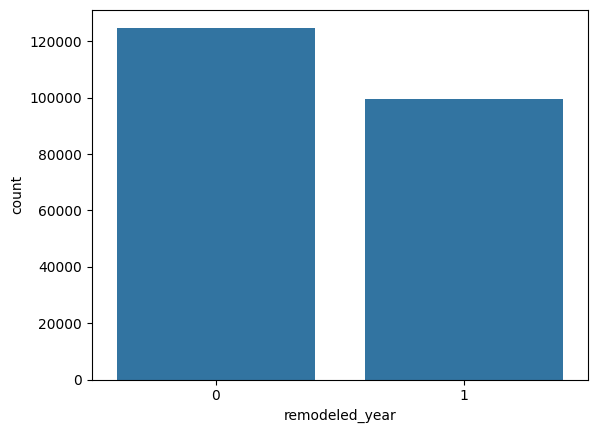

In [64]:
# Построим гистограмму распределения
sns.countplot(x = 'remodeled_year', data = df)

Получился бинарный сбалансированный признак, оставляем

#### heating - Отопление

In [65]:
# Извлечём из словаря признак наличия отопления heating
df['heating'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])

In [66]:
print('Уникальных значений: {}'.format(df['heating'].nunique()))
print('Пропусков: {}'.format(df['heating'].isna().sum()))
df['heating'].value_counts()[:30]

Уникальных значений: 1555
Пропусков: 2204


heating
Forced Air                     58374
                               39832
Forced air                     35680
Other                          20297
No Data                         6845
Gas                             5506
Electric                        5159
Central Air                     4796
Heat Pump                       4532
Central Electric                4350
Central                         3794
Baseboard                       2955
Central, Electric               2762
Wall                            2390
Electric Heat                   2213
Heat pump                       1913
Heating System                  1760
Radiant                         1097
Forced air, Heat pump           1076
Natural Gas Heat                 840
Central Furnace                  811
Central Air, Ceiling Fan(s)      808
Gas Heat                         686
Forced Air, Gas                  607
Forced Air Heating               547
, Gas Hot Air/Furnace            546
Forced Air, Natural Gas       

In [67]:
# Приведем все значения к нижнему регистру и посомтрим на результат
df['heating'] = df['heating'].apply(lambda x: str(x).lower())
df.heating.value_counts()[:30]

heating
forced air                     94054
                               39832
other                          20297
no data                         6845
heat pump                       6445
gas                             5508
electric                        5162
central air                     4796
central electric                4350
central                         3794
baseboard                       2955
central, electric               2762
wall                            2390
none                            2266
electric heat                   2213
heating system                  1760
forced air, heat pump           1101
radiant                         1097
natural gas heat                 840
central furnace                  811
central air, ceiling fan(s)      808
gas heat                         686
forced air, gas                  607
forced air heating               547
, gas hot air/furnace            546
forced air, natural gas          495
central gas                   

In [68]:
# Произведем замену синонимов и одинаковых по смыслу значений
df['heating'] = df['heating'].apply(lambda x: 'no data' if (x == '') | (x == ' ') | (x == None) else x)
df['heating'] = df['heating'].apply(lambda x: 'forced air' if (x == 'central air') | (x == 'forced air heating') |
                                    (x == 'forced air, heat pump') | (x == ', heat pump - heat') | (x == 'central, heat pump') | 
                                    (x == 'baseboard, forced air') else x)
df['heating'] = df['heating'].apply(lambda x: 'electric' if (x == 'central electric') | (x == 'electric heat') | 
                                    (x == 'central, electric') | (x == 'central air, ceiling fan(s)') | 
                                    (x == 'central electric, zoned') | (x == 'central electric, heat pump') else x)
df['heating'] = df['heating'].apply(lambda x: 'gas' if (x == 'natural gas heat') | (x == 'gas heat') | 
                                    (x == 'natural gas') | (x == 'central gas') | (x == 'central, gas') | 
                                    (x == 'forced air, gas') | (x == ', gas hot air/furnace ') | 
                                    (x == 'forced air, natural gas ') | (x == 'electric, gas') | 
                                    (x == ', gas hot air/furnace') | (x == 'forced air, natural gas') | (x == 'propane') else x) 
df['heating'] = df['heating'].apply(lambda x: 'central' if (x == 'central furnace') | (x == 'central air, central heat') | (x == 'central heating') | (x == 'central air conditioning')  else x)


In [69]:
# Надем кол-во признков, которм соотвествует 90% всех данных
top_heating_Types_count = int(np.percentile(list(df.heating.value_counts()), 90))
print('90% от всех признаков заключено в {} категориях'.format(top_heating_Types_count))

# Посмотрим на эти категории
list(df.heating.value_counts())
df.heating.value_counts()[:top_heating_Types_count]

90% от всех признаков заключено в 12 категориях


heating
forced air        101103
no data            46677
other              20297
electric           16128
gas                 9720
heat pump           6445
central             5453
baseboard           2955
wall                2390
none                2266
heating system      1760
radiant             1097
Name: count, dtype: int64

In [70]:
df_copy_after_heating = df.copy()

In [71]:
# Удаляем не ТОП категории
all_heatingTypes = set(df.heating.value_counts().index)
main_heatingTypes = set(df.heating.value_counts().index[:top_heating_Types_count])
heatingTypes_to_drop = list(all_heatingTypes - main_heatingTypes)
df.drop(df.loc[df['heating'].isin(heatingTypes_to_drop), 'heating'].index, inplace = True)
df.reset_index(inplace = True, drop = True)


#### cooling - Кондиционирование

In [72]:
# Извлечём из словаря признак наличия кондиционирования cooling.
df['cooling'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [73]:
print('Уникальных значений: {}'.format(df['cooling'].nunique()))
print('Пропусков: {}'.format(df['cooling'].isna().sum()))
print('Всего значений: {}'.format(df['cooling'].count()))
df.cooling.value_counts()[:30]

Уникальных значений: 732
Пропусков: 2204
Всего значений: 214087


cooling
Central                                            107369
                                                    49490
Central Air                                          8337
No Data                                              8181
Has Cooling                                          5592
None                                                 5498
Central Electric                                     3964
Wall                                                 2947
Central Gas                                          1810
Cooling System                                       1754
Central Heating                                      1581
Other                                                1319
Central A/C                                          1200
Refrigeration                                         960
Central A/C (Electric), Central Heat (Gas)            931
Evaporative                                           863
Central A/C (Electric), Central Heat (Electric)       769
Refrig

In [74]:
# Приведем все значения к нижнему регистру и посомтрим на результат
df['cooling'] = df['cooling'].apply(lambda x: str(x).lower())
df.cooling.value_counts()[:30]

cooling
central                                            107369
                                                    49490
central air                                          8337
no data                                              8181
none                                                 7702
has cooling                                          5592
central electric                                     3964
wall                                                 2947
central gas                                          1810
cooling system                                       1754
central heating                                      1581
other                                                1319
central a/c                                          1200
refrigeration                                         960
central a/c (electric), central heat (gas)            931
evaporative                                           863
central a/c (electric), central heat (electric)       769
refrig

In [75]:
# Закодируем значения. 1 - если есть кондиционнирование и 0 - если нет
df['cooling'] = df['cooling'].apply(lambda x: 0 if (x == None) | (x == '') | (x == 0) |(x == 'no data') | (x == 'none') | (x == ' ') else x)
df['cooling'] = df['cooling'].apply(lambda x: 0 if (x == 0) | (x == '0') else 1)
df.cooling.value_counts()[:50]

cooling
1    150918
0     65373
Name: count, dtype: int64

#### parking - Парковка (гараж)

In [76]:
# Извлечём из словаря признак наличия парковки parking
df['parking'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

In [77]:
print('Всего значений: {}'.format(df['parking'].count()))
print('Уникальных значений: {}'.format(df['parking'].nunique()))
print('Пропусков: {}'.format(df['parking'].isna().sum()))
df.parking.value_counts()[:30]

Всего значений: 214087
Уникальных значений: 2148
Пропусков: 2204


parking
                                    75537
Attached Garage                     48399
2 spaces                            20004
1 space                             10454
Detached Garage                      9959
No Data                              9488
Carport                              5711
3 spaces                             2696
Off Street                           2472
1                                    2279
2                                    2066
Carport, Attached Garage             1870
None                                 1782
4 spaces                             1713
Off street                           1095
Attached Garage, Detached Garage      934
On Street                             825
0                                     687
Attached Garage, Carport              585
Parking Desc                          559
Detached Garage, Attached Garage      508
4                                     434
6 spaces                              397
Driveway                  

In [78]:

# Переведем в нижний регистр
df['parking'] = df['parking'].apply(lambda x: str(x).lower())

# Стандартизируем значения где гаража нет
df['parking'] = df['parking'].apply(lambda x: '0 spaces' if (x == '0') | (x == '') | (x == ' ') | (x == None) | (x == 'no data') 
                                    | (x == 'none') | (x == 'on street') | (x == 'driveway') | (x == 'carport') else x)
# Стандартизируем от одного гаражного места
df['parking'] = df['parking'].apply(lambda x: '1 spaces' if (x == '1') | (x == '1 space') else x)
# Стандартизируем написание одного гаражного места
df['parking'] = df['parking'].apply(lambda x: '1 spaces' if (x == '1') | (x == '1 space') else x)
# Стандартизируем написание двух гаражных мест
df['parking'] = df['parking'].apply(lambda x: '2 spaces' if (x == '2') | (x == '1 space') else x)
# Стандартизируем написание трех гаражных мест
df['parking'] = df['parking'].apply(lambda x: '3 spaces' if (x == '3') | (x == '3 space') else x)
# Стандартизируем написание четырех гаражных мест
df['parking'] = df['parking'].apply(lambda x: '4 spaces' if (x == '4') | (x == '4 space') else x)
# Стандартизируем написание detached garage
df['parking'] = df['parking'].apply(lambda x: 'detached garage' if (x == 'carport, detached garage') else x)
# Стандартизируем написание attached garage
df['parking'] = df['parking'].apply(lambda x: 'attached garage' if (x == 'carport, attached garage') 
                                    | (x == 'attached garage, detached garage') | (x == 'attached garage, carport') 
                                    | (x == 'detached garage, attached garage') | (x == 'off street, attached garage') else x)

In [79]:
# Определим самые популярные значения, которые описывают 90% примеров
top_parking_count_list = int(np.percentile(list(df.parking.value_counts()), 90))

# Посмотрим на эти категории
list(df.parking.value_counts())
df.parking.value_counts()[:top_parking_count_list]

parking
0 spaces           96940
attached garage    52672
2 spaces           22070
1 spaces           12733
detached garage    10252
off street          3567
3 spaces            3018
4 spaces            2147
Name: count, dtype: int64

In [80]:
df_copy_after_parking = df.copy()

In [81]:
# Заменим не топ значения на 'other'
all_parking_set = set(df.parking.value_counts().index) # Создаем множество со всеми признаками
main_parking_set = set(df.parking.value_counts().index[:top_parking_count_list]) # Множество с Топ признаками (90%)
parking_replacement_list = list(all_parking_set - main_parking_set) # Список со значениями которые будем заменять
df.loc[df['parking'].isin(parking_replacement_list), 'parking'] = 'other'
df.parking.value_counts()

parking
0 spaces           96940
attached garage    52672
2 spaces           22070
other              12892
1 spaces           12733
detached garage    10252
off street          3567
3 spaces            3018
4 spaces            2147
Name: count, dtype: int64

#### lotsize - Размер участка

In [82]:
# Извлечём из словаря признак lotsize (площадь земельного участка)
df['lotsize'] = df['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])

In [83]:
print('Всего значений: {}'.format(df['lotsize'].count()))
print('Уникальных значений: {}'.format(df['lotsize'].nunique()))
print('Пропусков: {}'.format(df['lotsize'].isna().sum()))

df.lotsize.value_counts()[:30]

Всего значений: 199624
Уникальных значений: 27113
Пропусков: 16667


lotsize
               17314
—              10108
No Data         4179
-- sqft lot     2774
0.26 acres      1509
0.25 acres      1290
0.28 acres      1250
6,098 sqft      1206
0.27 acres      1194
0.29 acres      1142
4,356 sqft      1098
7,405 sqft      1032
6,534 sqft      1003
5,227 sqft       996
10,000 sqft      976
0.34 acres       972
0.3 acres        958
3,920 sqft       875
0.31 acres       780
0.32 acres       749
8,276 sqft       746
5,000 sqft       739
8,712 sqft       737
4,792 sqft       665
0.33 acres       642
0.35 acres       622
9,583 sqft       561
0.46 acres       558
3,049 sqft       546
4,791 sqft       538
Name: count, dtype: int64

In [84]:
# Переведем в нижний регистр
df['lotsize'] = df['lotsize'].apply(lambda x: str(x).lower())
# Найдем и преобразуем пустые значения
df['lotsize'] = df['lotsize'].apply(lambda x: None if (x == '') | (x == ' ') | (x == None) | (x == '—') 
                                    | (x == 'none') | (x == '-- sqft lot') | (x == 'no data') else x)
df.lotsize.value_counts()[:30]

lotsize
0.26 acres     1780
0.28 acres     1495
0.25 acres     1449
0.27 acres     1435
0.29 acres     1327
6,098 sqft     1206
0.34 acres     1119
4,356 sqft     1098
7,405 sqft     1032
6,534 sqft     1003
5,227 sqft      996
10,000 sqft     976
0.3 acres       958
0.31 acres      955
0.32 acres      889
3,920 sqft      875
0.33 acres      775
8,276 sqft      746
5,000 sqft      739
8,712 sqft      737
0.35 acres      731
0.46 acres      668
4,792 sqft      665
1 acre          660
0.36 acres      635
0.37 acres      634
9,583 sqft      561
0.39 acres      549
3,049 sqft      546
4,791 sqft      538
Name: count, dtype: int64

In [85]:
# Разделим числовую и текстовую часть информации на два столбца
df[['lotsize_value', 'lotsize_measureUnit']] = df['lotsize'].str.split(' ', n=1, expand=True)
# Устраняем дубли в обозначении единиц измерений
df['lotsize_measureUnit'] = df['lotsize_measureUnit'].apply(lambda x: 'sqft' if (x == 'sqft') | (x == 'sq. ft.') | (x == 'sqft lot') else 'acres')
df.lotsize_measureUnit.value_counts()

lotsize_measureUnit
acres    111341
sqft     104950
Name: count, dtype: int64

In [86]:
# Переводим в числовой формат
df['lotsize_value'] = df['lotsize_value'].str.replace(',', '').astype(float)

In [87]:
df.lotsize_value.value_counts()

lotsize_value
0.26        1987
6098.00     1974
7405.00     1935
0.25        1659
0.28        1657
            ... 
4572.00        1
3903.00        1
5966.00        1
53539.00       1
582.00         1
Name: count, Length: 14415, dtype: int64

In [88]:
# Произведем перевод в квадратные метры
col1         = 'lotsize_measureUnit'
col2         = 'lotsize_value'
conditions  = [ df[col1] =='acres', df[col1] =='sqft' ]
choices     = [ df[col2]*4047, df[col2]*10.76 ]
    
df['lotsize_square_meters'] = np.select(conditions, choices, default=np.nan)
#df.lotsize_square_meters.value_counts()
#df.lotsize_square_meters.apply(np.round).value_counts()
#df['lotsize_square_meters'] = df.lotsize_square_meters.apply(np.round).value_counts()
#df['lotsize_square_meters'] = df['lotsize_square_meters'].round(2)
#df.lotsize_square_meters.value_counts()
df['lotsize_square_meters']

0         6.270928e+04
1         9.281576e+04
2         7.316800e+03
3         9.415000e+04
4         5.041834e+08
              ...     
216286    8.596164e+04
216287    8.289504e+04
216288             NaN
216289    1.721600e+04
216290             NaN
Name: lotsize_square_meters, Length: 216291, dtype: float64

In [ ]:
print('Всего значений: {}'.format(df['lotsize_square_meters'].count()))
print('Уникальных значений: {}'.format(df['lotsize_square_meters'].nunique()))
print('Пропусков: {}'.format(df['lotsize_square_meters'].isna().sum()))

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/4194488451.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/4194488451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


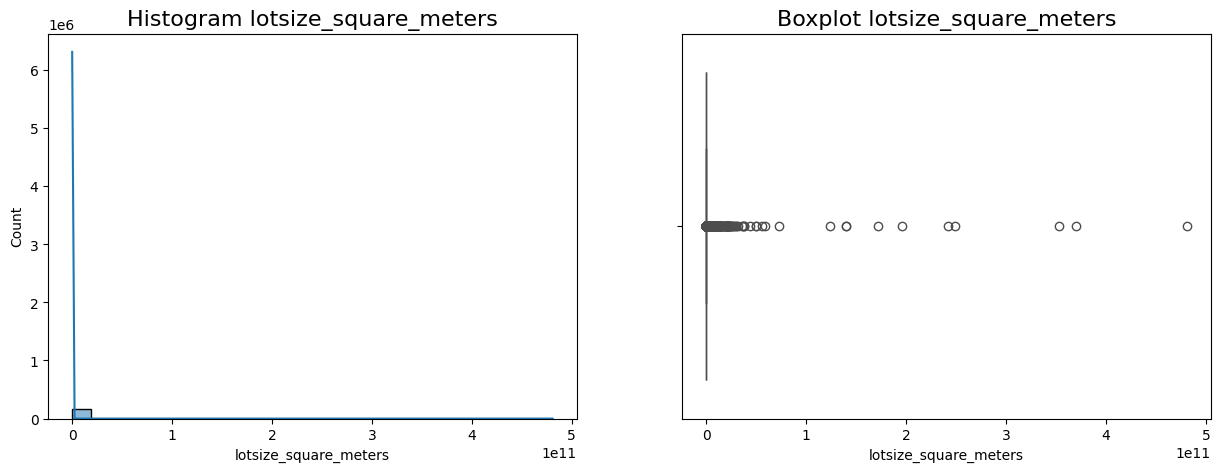

In [90]:
# Гисторграмма и коробчатая диаграмма распределения площади
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='lotsize_square_meters',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram lotsize_square_meters', fontsize=16);
sns.boxplot(
    data=df,
    x='lotsize_square_meters',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot lotsize_square_meters', fontsize=16);

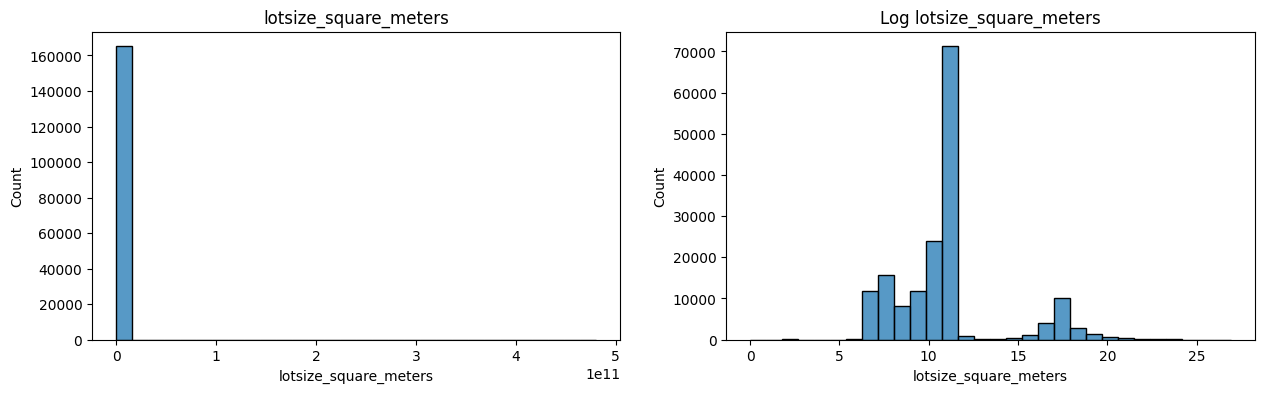

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(df['lotsize_square_meters'], bins=30, ax=axes[0])
histplot.set_title('lotsize_square_meters');

#гистограмма в логарифмическом масштабе
log_lotsize_square_meters = np.log(df['lotsize_square_meters'] + 1)
histplot = sns.histplot(log_lotsize_square_meters , bins=30, ax=axes[1])
histplot.set_title('Log lotsize_square_meters');

Левое распределение напоминает логнормальное распределение

In [94]:
# Прологарифмируем признак площади
df['lotsize_square_meters'] = np.log(df['lotsize_square_meters']+1)

In [96]:
outliers, cleaned = outliers_iqr(df, 'lotsize_square_meters')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 21231
Результирующее число записей: 144018


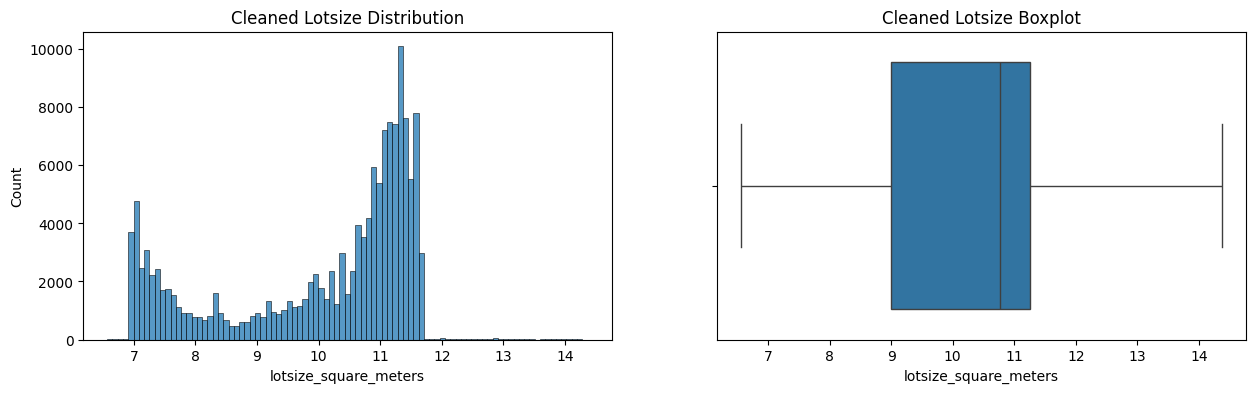

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='lotsize_square_meters', ax=axes[0]);
histplot.set_title('Cleaned Lotsize Distribution');
boxplot = sns.boxplot(data=cleaned, x='lotsize_square_meters', ax=axes[1]);
boxplot.set_title('Cleaned Lotsize Boxplot');

Легко заметить, среднее значение (жирная вертикальная линия) находится правее моды, это свойство распределений с правосторонней асимметрией

In [98]:
df_copy_after_lotsize = df.copy()

In [99]:
# Переопределяем df на очищенные даныне по признаку year_built
df = cleaned.copy()

In [100]:
# Сощдадим новый столбец со значеним логарифма
df['lotsize_square_meters_log'] = df['lotsize_square_meters']

In [101]:
# Удалим столбцы, больше не пригодятся
df.drop(['lotsize_value', 'lotsize_measureUnit', 'lotsize', 'lotsize_square_meters'],axis=1,inplace=True) # удалим столбцы

In [102]:
df.reset_index(inplace = True, drop = True)

In [103]:
df.describe().round()

,baths,PrivatePool,year_built,remodeled_year,cooling,lotsize_square_meters_log
count,144018.0,144018.0,144018.0,144018.0,144018.0,144018.0
mean,2.0,0.0,1974.0,1.0,1.0,10.0
std,1.0,0.0,33.0,0.0,0.0,2.0
min,1.0,0.0,1882.0,0.0,0.0,7.0
25%,2.0,0.0,1951.0,0.0,0.0,9.0
50%,2.0,0.0,1978.0,1.0,1.0,11.0
75%,3.0,0.0,2004.0,1.0,1.0,11.0
max,4.0,1.0,2022.0,1.0,1.0,14.0


#### Price/sqft - Цена за квадратный метр

Не будем использовать признак так как он отражает целевой признак цены.

### fireplace - Камин

In [106]:
print('Всего значений: {}'.format(df['fireplace'].count()))
print('Уникальных значений: {}'.format(df['fireplace'].nunique()))
print('Пропусков: {}'.format(df['fireplace'].isna().sum()))
df.fireplace.value_counts()[:30]

Всего значений: 50819
Уникальных значений: 189
Пропусков: 93199


fireplace
yes                                       31642
Yes                                       12021
1                                          4326
Not Applicable                             1149
2                                           577
3                                           169
0                                           115
Wood Burning                                 68
Living Room                                  56
Living Room, Wood Burning                    55
4                                            54
Family Room, Wood Burning                    48
1 Fireplace                                  40
Family Room                                  38
Gas Log, 1 Fireplace                         30
N/K                                          21
5                                            20
Other (See Remarks)                          16
Gas, Family Room                             14
Gas                                          13
3+                            

Очень много пропусков, проведем более детальный анализ пропущеных значений в df

In [107]:
# Вычислим средний по столбцам результат метода isnull(). Получим долю пропусков в каждом столбце.
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

fireplace       64.713439
stories         27.122304
beds            13.732311
status           9.746698
propertyType     3.712036
sqft             2.260134
target           1.242900
dtype: float64

Можно увидеть, что у нас большое число пропусков (более 64 %) в fireplace (наличие камина).

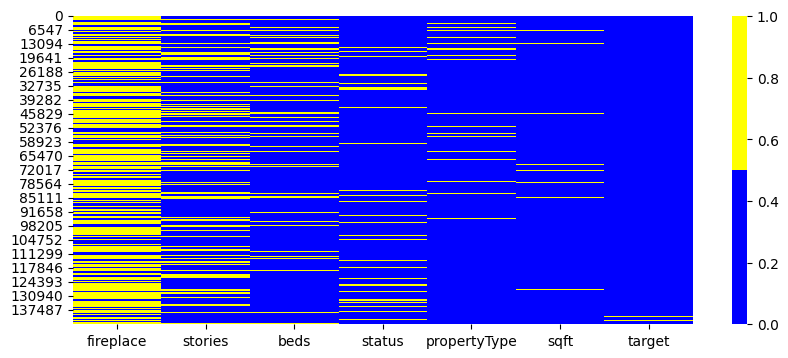

In [108]:
#  Построим тепловую карту пропусков
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    df[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [109]:
# Пропуски заполним значением 'no', так как если будем удалять потеряем больше половины данных
df.fireplace = df.fireplace.fillna('no')

In [110]:
# Приводим к нижнему регистру
df['fireplace'] = df['fireplace'].apply(lambda x: str(x).lower())
df.fireplace.value_counts()[:30]

fireplace
no                                        93199
yes                                       43663
1                                          4326
not applicable                             1149
2                                           577
3                                           169
0                                           115
wood burning                                 68
living room                                  56
living room, wood burning                    55
4                                            54
family room, wood burning                    48
1 fireplace                                  40
family room                                  38
gas log, 1 fireplace                         30
n/k                                          21
5                                            20
other (see remarks)                          16
gas, family room                             14
gas                                          13
3+                            

In [111]:
# Кодируем 0 если нет сигнализации иначе 1
df['fireplace'] = df['fireplace'].apply(lambda x: 0 if (x=='0') | (x=='no') | (x=='not applicable') else 1)

In [260]:
df.fireplace.value_counts()

fireplace
0    64307
1    36435
Name: count, dtype: int64

### city - Город

In [113]:
print('Всего значений: {}'.format(df['city'].count()))
print('Уникальных значений: {}'.format(df['city'].nunique()))
print('Пропусков: {}'.format(df['city'].isna().sum()))

Всего значений: 144018
Уникальных значений: 1271
Пропусков: 0


In [114]:
# Город важный аспект в определения цены, все пропуска, а их очень мало - удаляем
df = df.dropna(subset=['city'])

### Словарь schools

In [115]:
print('Всего значений: {}'.format(df['schools'].count()))
print('Уникальных значений: {}'.format(df['schools'].nunique()))
print('Пропусков: {}'.format(df['schools'].isna().sum()))
#df.schools.value_counts()[:30]

Всего значений: 144018
Уникальных значений: 131850
Пропусков: 0


В столбце типом данных является строка, в которой закодирован список. В списке в свою очередь заключен словарь. Применим функцию eval для раскодировки списка.

In [116]:
# Копирование
#df['schools_copy'] = df['schools']

In [ ]:
# Восстановление
df['schools'] = df['schools_copy']


In [117]:
df['schools'] = df['schools'].apply(eval)

In [118]:
df.schools.loc[0]

[{'rating': ['4/10', 'None/10', '4/10'],
  'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'],
   'Grades': ['9-12', '3-8', 'PK-8']},
  'name': ['East Valley High School&Extension',
   'Eastvalley Middle School',
   'Trentwood Elementary School']}]

Здесь содержатся данные о школах, расположенных рядом с домом, такие как: rating - рейтинги школ, Distance - расстояния до школ, Grades - возрастной уровень школ и name - названия школ. Из данного столбца для упрощения возьмем количество  расположенных рядом школ - 'number_of_schools' 

#### number_of_schools - Количесвто расположенных рядом школ

In [119]:
df['number_of_schools'] = df['schools'].apply(lambda x: len(x[0]['rating']))

In [120]:
df.number_of_schools.loc[0]

3

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/2181940190.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/2181940190.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


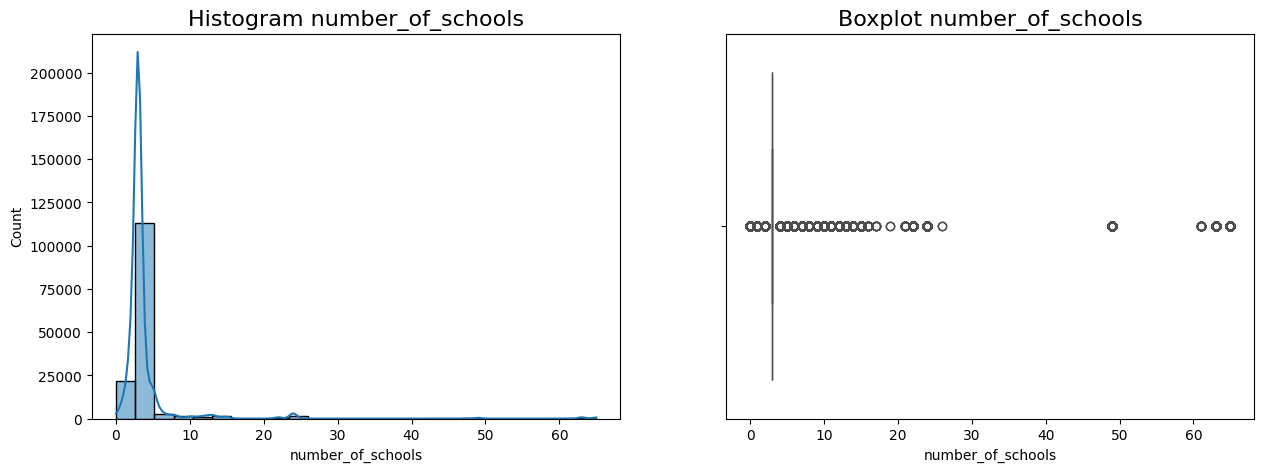

In [121]:

fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='number_of_schools',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram number_of_schools', fontsize=16);
sns.boxplot(
    data=df,
    x='number_of_schools',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot number_of_schools', fontsize=16);

In [123]:
outliers, cleaned = outliers_z_score(df, 'number_of_schools', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 4277
Результирующее число записей: 139741


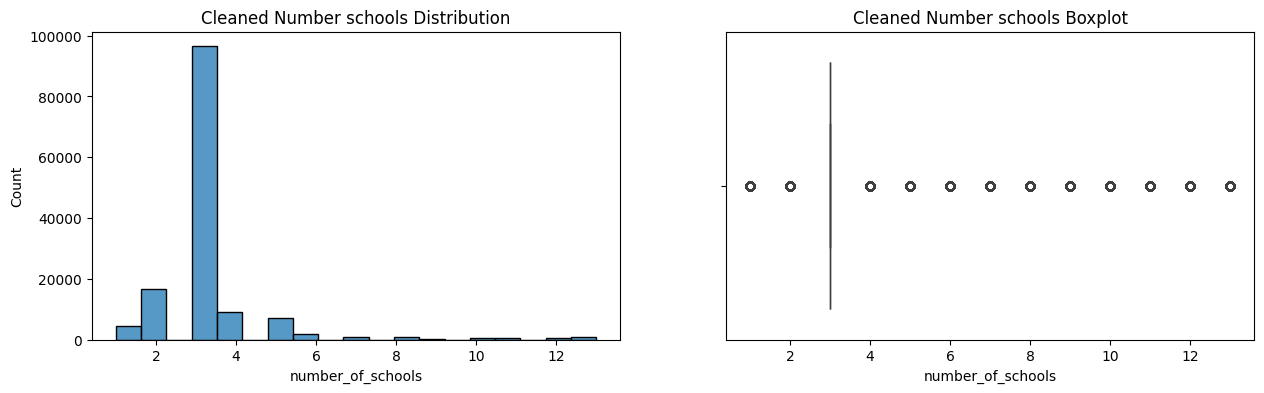

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='number_of_schools', ax=axes[0]);
histplot.set_title('Cleaned Number schools Distribution');
boxplot = sns.boxplot(data=cleaned, x='number_of_schools', ax=axes[1]);
boxplot.set_title('Cleaned Number schools Boxplot');

In [125]:
# Переопределяем df на очищенные данные по признаку number_of_schools
df_copy_after_number_of_schools = df.copy()

In [126]:
# Переопределяем df на очищенные данные по признаку number_of_schools
df = cleaned.copy()

### sqft - Жилая площадь 

In [128]:
print('Всего значений: {}'.format(df['sqft'].count()))
print('Уникальных значений: {}'.format(df['sqft'].nunique()))
print('Пропусков: {}'.format(df['sqft'].isna().sum()))
df['sqft'].value_counts()[:30]

Всего значений: 136522
Уникальных значений: 14087
Пропусков: 3219


sqft
1,200 sqft    548
1,000 sqft    396
1,800 sqft    361
2,000 sqft    357
1,400 sqft    338
1,500 sqft    325
1,100 sqft    303
1,600 sqft    295
1,300 sqft    278
900 sqft      275
800 sqft      256
2,200 sqft    247
2,400 sqft    243
2,100 sqft    225
1,440 sqft    224
960 sqft      218
1,152 sqft    215
1,120 sqft    206
1,700 sqft    189
3,000 sqft    188
1,080 sqft    186
2,500 sqft    179
1,320 sqft    174
1,344 sqft    171
750 sqft      166
1,056 sqft    164
1,248 sqft    163
1,350 sqft    162
1,250 sqft    158
1,008 sqft    151
Name: count, dtype: int64

In [129]:
# Очищаем от текста и округляем до целого числа признак кол-во ванных комнат
df['sqft'] = df['sqft'].str.replace(r"[^\d\.]", "", regex=True) # удаляем текст
df['sqft'] = np.floor(pd.to_numeric(df['sqft'], errors='coerce')).astype('Int64') # переводим в числовой формат 

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/1374637325.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/1374637325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


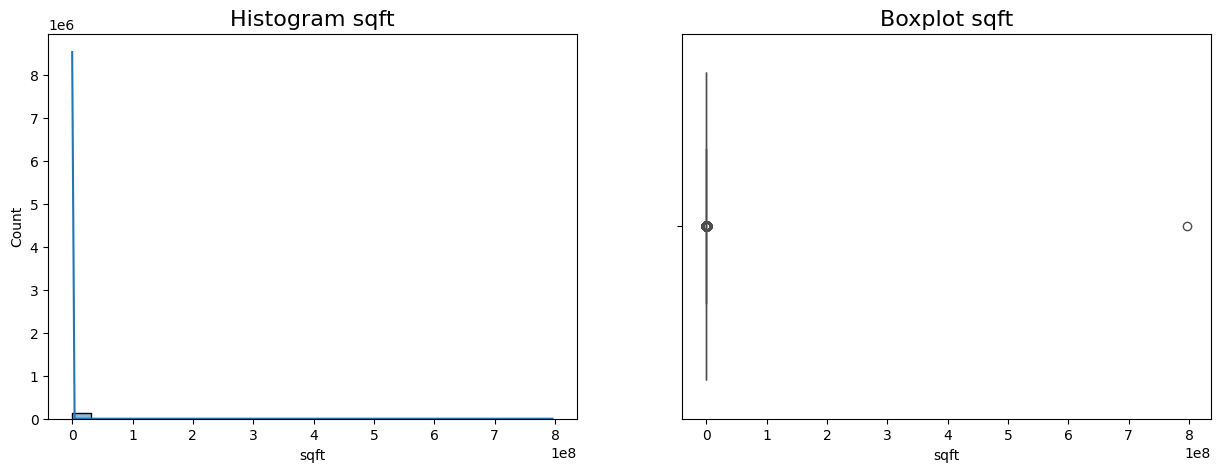

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='sqft',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram sqft', fontsize=16);
sns.boxplot(
    data=df,
    x='sqft',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot sqft', fontsize=16);

In [133]:
outliers, cleaned = outliers_iqr(df, 'sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 4854
Результирующее число записей: 131580


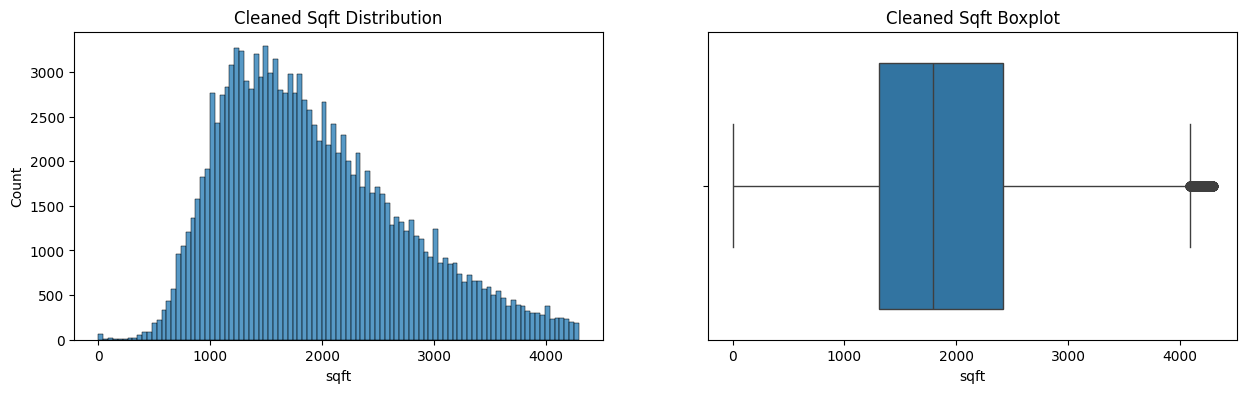

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='sqft', ax=axes[0]);
histplot.set_title('Cleaned Sqft Distribution');
boxplot = sns.boxplot(data=cleaned, x='sqft', ax=axes[1]);
boxplot.set_title('Cleaned Sqft Boxplot');

Распределение уже больше похоже на реальный рынок недвижимости: основная часть домов имеет площадь в интервале от 1500 до 2500 кв. футов, а далее частота наблюдений постепенно падает.

In [135]:
# Сохраним копию df до преобразования
df_copy_after_sqft = df.copy()

In [136]:
# Переопределяем df на очищенные данные по признаку sqft
df = cleaned.copy()

### zipcode - Почтовый индекс

In [137]:
print('Всего значений: {}'.format(df['zipcode'].count()))
print('Уникальных значений: {}'.format(df['zipcode'].nunique()))
print('Пропусков: {}'.format(df['zipcode'].isna().sum()))
df['zipcode'].unique()

Всего значений: 131580
Уникальных значений: 3526
Пропусков: 0


array(['99216', '90049', '77080', ..., '48234', '94102', '89086'],
      dtype=object)

Данный являются почтовым индексом, с предсказанием они не помогут, удаляем

In [138]:
# Удаляем столбец
df.drop('zipcode', axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)

### beds - Количество спален в доме

In [140]:
print('Всего значений: {}'.format(df['beds'].count()))
print('Уникальных значений: {}'.format(df['beds'].nunique()))
print('Пропусков: {}'.format(df['beds'].isna().sum()))
df.beds.value_counts()[:50]

Всего значений: 115347
Уникальных значений: 52
Пропусков: 16233


beds
3 Beds     31452
4 Beds     19619
2 Beds     11802
3          11359
3 bd        8542
4           7051
4 bd        5108
5 Beds      4541
Baths       4014
2           2986
2 bd        2390
5           1482
6 Beds      1343
5 bd        1194
-- bd        383
7 Beds       346
1 bd         270
8 Beds       261
1            213
6            207
             203
6 bd         174
9 Beds        86
0             70
Bath          56
7 bd          37
10 Beds       27
7             24
8 bd          23
12 Beds       15
11 Beds       14
8              8
2.0            7
9              5
9 bd           5
1.0            5
10             3
14 Beds        3
10 bd          3
23 Beds        2
12 bd          2
3.0            2
28 Beds        1
20             1
18 Beds        1
46 bd          1
16 Beds        1
11 bd          1
44 Beds        1
47 Beds        1
Name: count, dtype: int64

In [141]:
# Очищаем от текста и округляем до целого числа признак кол-во спальных комнат
df['beds'] = df['beds'].str.replace(r"[^\d\.]", "", regex=True) # удаляем текст
df['beds'] = np.floor(pd.to_numeric(df['beds'], errors='coerce')).astype('Int64') # переводим в числовой формат 

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/1602260361.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/1602260361.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


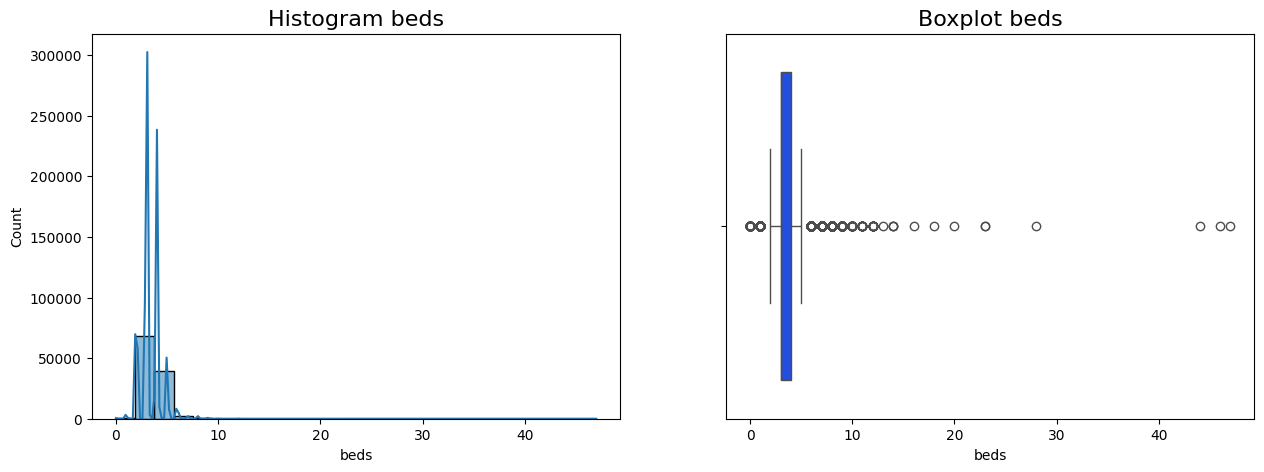

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='beds',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram beds', fontsize=16);
sns.boxplot(
    data=df,
    x='beds',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot beds', fontsize=16);

In [154]:
outliers, cleaned = outliers_z_score(df, 'beds', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 1024
Результирующее число записей: 109666


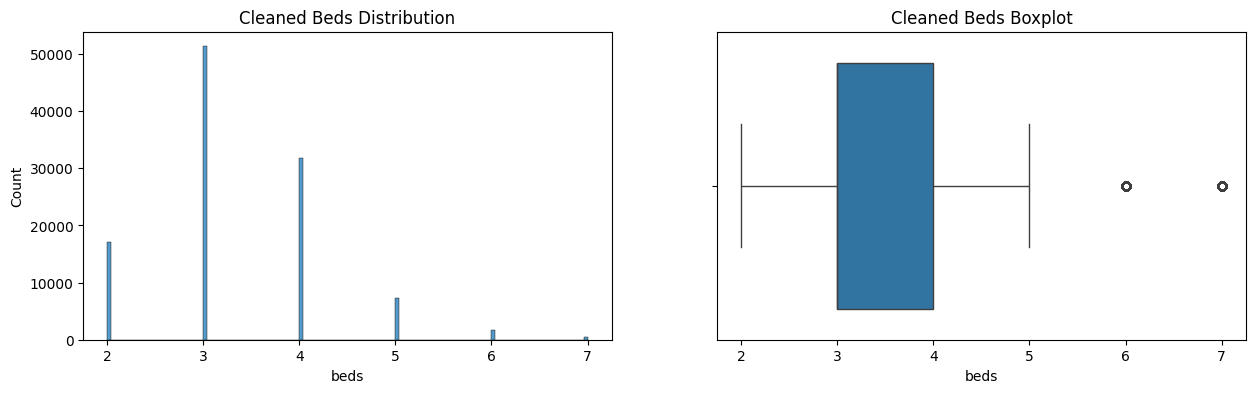

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='beds', ax=axes[0]);
histplot.set_title('Cleaned Beds Distribution');
boxplot = sns.boxplot(data=cleaned, x='beds', ax=axes[1]);
boxplot.set_title('Cleaned Beds Boxplot');

Распределение похоже на реальное, основная часть домов имеет от 3 до 4 спальных комнат.

In [156]:
# # Сохраним копию df до преобразования
df_copy_after_beds = df.copy()

# Переопределяем df на очищенные данные по признаку beds
df = cleaned.copy()

df.reset_index(inplace = True, drop = True)

### state - Штаты

In [158]:
print('Всего значений: {}'.format(df['state'].count()))
print('Уникальных значений: {}'.format(df['state'].nunique()))
print('Пропусков: {}'.format(df['state'].isna().sum()))
df.state.value_counts()[:30]

Всего значений: 109666
Уникальных значений: 25
Пропусков: 0


state
FL    26952
TX    25083
CA     9959
NY     6744
NC     5811
NV     4925
TN     4459
IL     4068
WA     3486
PA     2969
GA     2867
OH     2611
MI     2375
IN     1889
CO     1707
OR     1541
UT      669
DC      643
MO      516
MA      266
MD       69
AZ       42
VA       13
NJ        1
IA        1
Name: count, dtype: int64

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/1388653389.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/1388653389.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


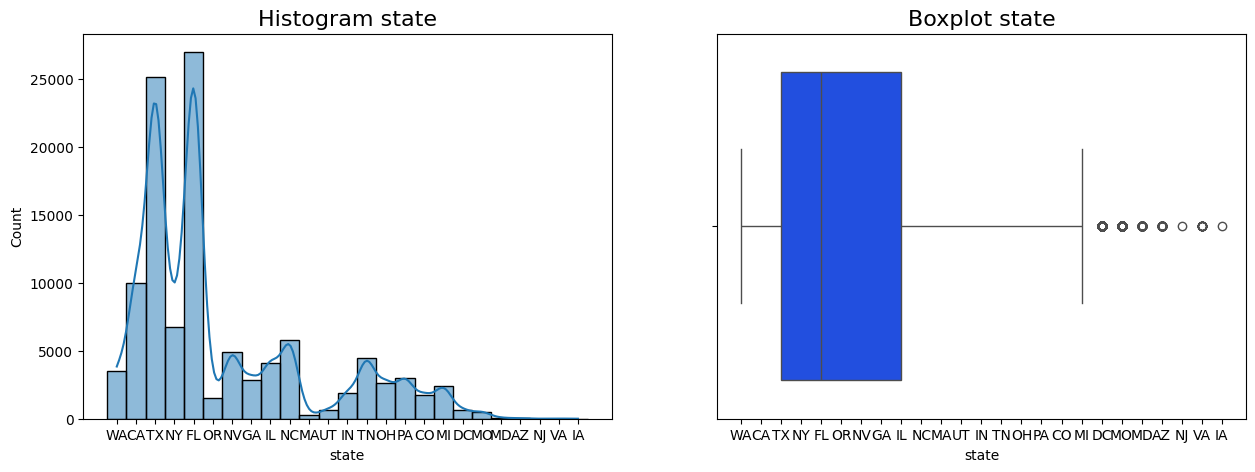

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='state',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram state', fontsize=16);
sns.boxplot(
    data=df,
    x='state',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot state', fontsize=16);

Получаем левое распределение, в данном случае нас оно полностью устраивает ввиду того, что в некоторых штатах больше предложений о продажи недвижимости.

### stories - Этажность недвижимости

In [160]:
print('Всего значений: {}'.format(df['stories'].count()))
print('Уникальных значений: {}'.format(df['stories'].nunique()))
print('Пропусков: {}'.format(df['stories'].isna().sum()))
df['stories'].unique()

Всего значений: 87747
Уникальных значений: 95
Пропусков: 21919


array(['2.0', '1.0', nan, '0.0', '0', '9.0', '1', '3', '2', '3.0', '4.0',
       '11', '4', '22.0', '6.0', '6', '8.0', '18.0', '22', '5.0', '11.0',
       '12.0', '33.0', '9', '16', '20', '31.0', '38', '25.0', '16.0',
       '21', '12', '7.0', '78.0', '5', '17.0', '47', '14', '10.0', '25',
       '7', '14.0', '48', '33', '32.0', '45', '43.0', '58.0', 'Townhouse',
       '24.0', '42.0', '20.0', '27', '13.0', '19.0', '46', '15', '15.0',
       '26.0', '78', '90.0', '42', '8', '30', '1.00', '23.0', '21.0',
       '35', '2 Stories', '58', '27.0', '40.0', '52.0', '66.0', '13',
       'Two Story or More', '38.0', '2.00', '45.0', '43', '39.0', '30.0',
       '40', '36.0', '57.0', '96.0', '49.0', '48.0', '10', '32', '24',
       '34.0', '41', '23', '17', '47.0'], dtype=object)

Мы наблюдаем, что практически 1/3 данных пропущена. Лучше не использовать признак, удалив его

In [161]:
df.drop('stories', axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)

### target - Целевой признак - Цена недвижимости

In [162]:
print('Всего значений: {}'.format(df['target'].count()))
print('Уникальных значений: {}'.format(df['target'].nunique()))
print('Пропусков: {}'.format(df['target'].isna().sum()))
df['target'].unique()

Всего значений: 108328
Уникальных значений: 18552
Пропусков: 1338


array(['$310,000', '$2,895,000', '$311,995', ..., '$253,885', '$488,462',
       '$171,306'], dtype=object)

Нужно удалить пропущенные значения и преобразовать к числовому формату

In [163]:
# Удаляем пропущенные значения в целевом признаке
df = df.dropna(subset=['target'])
df.reset_index(inplace = True, drop = True)

In [164]:
print('Пропусков: {}'.format(df['target'].isna().sum()))

Пропусков: 0


In [165]:
df.target.value_counts()[:20]

target
$225,000    604
$1,000      577
$299,900    572
$249,900    566
$199,900    556
$275,000    550
$325,000    525
$350,000    500
$250,000    481
$399,000    465
$425,000    459
$375,000    452
$215,000    438
$450,000    436
$299,000    434
$349,900    433
$239,900    430
$285,000    430
$265,000    419
$175,000    417
Name: count, dtype: int64

In [166]:
df['target'] = df['target'].str.replace(r"[^\d\.]", "", regex=True) # удаляем текст
df['target'] = np.floor(pd.to_numeric(df['target'], errors='coerce')).astype('Int64') # переводим в числовой формат

In [167]:
df.target.value_counts()[:20]

target
225000    605
1000      577
299900    573
249900    567
199900    558
275000    551
325000    526
350000    500
250000    485
399000    466
425000    459
375000    453
215000    438
450000    437
299000    437
349900    435
239900    433
285000    430
265000    420
399900    419
Name: count, dtype: Int64

/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/3954979315.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
/var/folders/gk/qgvlp_pn0tlb_n9svm1c7chh0000gp/T/ipykernel_7613/3954979315.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


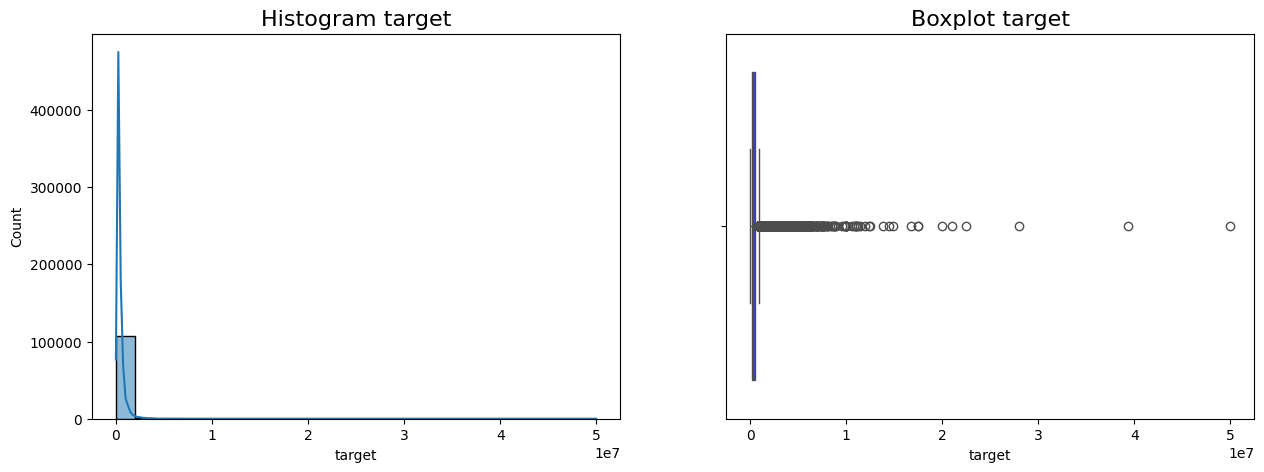

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(
    data=df,
    x='target',
    ax=axes[0],
    bins=25,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogram target', fontsize=16);
sns.boxplot(
    data=df,
    x='target',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot target', fontsize=16);

In [169]:
outliers, cleaned = outliers_iqr(df, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 7568
Результирующее число записей: 100742


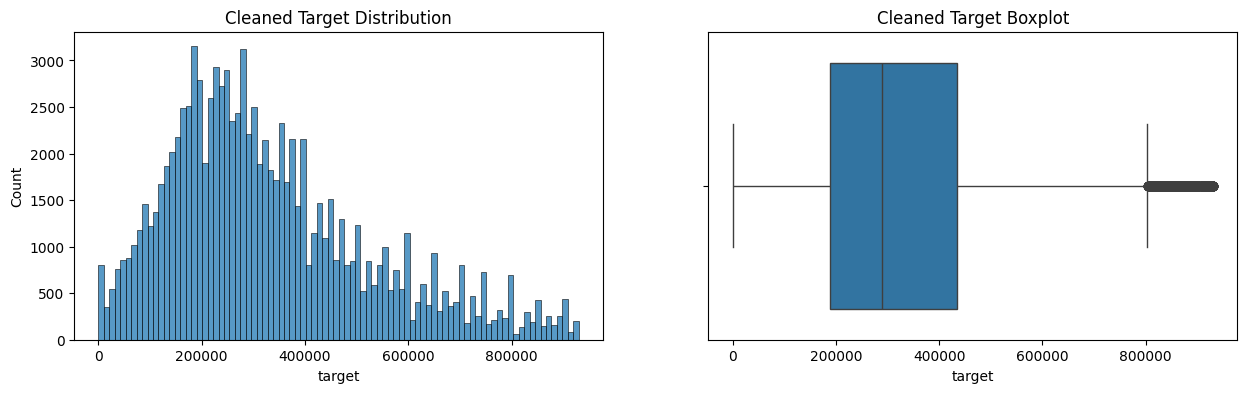

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='target', ax=axes[0]);
histplot.set_title('Cleaned Target Distribution');
boxplot = sns.boxplot(data=cleaned, x='target', ax=axes[1]);
boxplot.set_title('Cleaned Target Boxplot');

На первый взгляд — стерильно. Но коробчатая диаграмма всё ещё продолжает говорить, что в данных есть выбросы с правой стороны. Но так как дома могут быть очень дорогими (премиум жилье, большая площадь, участок). Средняя стоимости жилья лежит в диапазоне от $200.000 до $400.000

In [171]:
# Переопределяем df на очищенные данные по признаку target
df_copy_after_target = df.copy()
# Переопределяем df на очищенные данные по признаку target
df = cleaned.copy()

### status - Статус продажи

In [172]:
print('Всего значений: {}'.format(df['status'].count()))
print('Уникальных значений: {}'.format(df['status'].nunique()))
print('Пропусков: {}'.format(df['status'].isna().sum()))
df.status.value_counts()[:20]

Всего значений: 88299
Уникальных значений: 57
Пропусков: 12443


status
for sale                     59200
For sale                     20678
foreclosure                   3961
Pre-foreclosure               1198
New construction              1104
Pre-foreclosure / auction      708
 / auction                     518
Auction                        294
Foreclosure                    215
Foreclosed                     189
pending                         55
Active                          45
Pending                         39
Coming soon: Nov 29.             9
Coming soon: Dec 6.              6
Coming soon: Dec 4.              6
Coming soon: Nov 27.             5
Coming soon: Dec 5.              5
Under Contract Backups           5
Coming soon: Dec 13.             4
Name: count, dtype: int64

In [173]:
# Пропуски заполним значением 'no info'
df.status = df.status.fillna('no info')

In [174]:
# Переведем в нижний регистр
df['status'] = df['status'].apply(lambda x: str(x).lower())

In [175]:
# Определим самые популярные значения, которые описывают 80% примеров
top_list = int(np.percentile(list(df.status.value_counts()), 80))
top_list
# Посмотрим на эти категории
list(df.status.value_counts())
df.status.value_counts()[:top_list]

status
for sale                     79878
no info                      12443
foreclosure                   4176
pre-foreclosure               1198
new construction              1104
pre-foreclosure / auction      708
 / auction                     518
auction                        294
foreclosed                     189
pending                         94
active                          45
coming soon: nov 29.             9
coming soon: dec 6.              6
coming soon: dec 4.              6
under contract backups           5
coming soon: dec 5.              5
Name: count, dtype: int64

In [176]:
# Заменим не топ значения на 'other'
all_set = set(df.status.value_counts().index) # Создаем множество со всеми признаками
main_set = set(df.status.value_counts().index[:11]) # Множество с Топ признаками около 80%
replacement_list = list(all_set - main_set) # Список со значениями которые будем заменять
df.loc[df['status'].isin(replacement_list), 'status'] = 'other'
df.status.value_counts()

status
for sale                     79878
no info                      12443
foreclosure                   4176
pre-foreclosure               1198
new construction              1104
pre-foreclosure / auction      708
 / auction                     518
auction                        294
foreclosed                     189
other                           95
pending                         94
active                          45
Name: count, dtype: int64

### propertyType - Тип недвижимости

In [177]:
print('Всего значений: {}'.format(df['propertyType'].count()))
print('Уникальных значений: {}'.format(df['propertyType'].nunique()))
print('Пропусков: {}'.format(df['propertyType'].isna().sum()))
df.propertyType.value_counts()[:20]

Всего значений: 100742
Уникальных значений: 19
Пропусков: 0


propertyType
single-family home               48511
Single Family                    33737
townhouse                         5223
condo                             4654
Townhouse                         2829
multi-family                      2377
lot/land                          1296
mobile/manufactured                670
Condo                              517
coop                               459
Multi Family                       227
Mobile / Manufactured              141
Condo/Townhome/Row Home/Co-Op       61
apartment                           20
unknown                              6
Apartment                            5
Cooperative                          5
Single Family Home                   3
Miscellaneous                        1
Name: count, dtype: int64

In [178]:
# Переведем в нижний регистр
df['propertyType'] = df['propertyType'].apply(lambda x: str(x).lower())

In [180]:
# Произведем замену синонимов и одинаковых по смыслу значений
df['propertyType'] = df['propertyType'].apply(lambda x: 'single-family home' if (x == 'single family') | (x == 'single family home') else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'multi-family' if (x == 'multi family') else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'coop' if (x == 'cooperative') else x)

### street - Адрес дома

In [184]:
print('Всего значений: {}'.format(df['street'].count()))
print('Уникальных значений: {}'.format(df['street'].nunique()))
print('Пропусков: {}'.format(df['street'].isna().sum()))
df.street.value_counts()[:20]

Всего значений: 100742
Уникальных значений: 99579
Пропусков: 0


street
Address Not Disclosed      252
(undisclosed Address)       73
139 Walnut Dr                3
5817 Wake Robin Dr           3
2206 Orono Landing Ln        2
1510 Jenni Lee Ct            2
445 S Deerwood Ave           2
14615 Hampton Green Ln       2
5627 SW Coronado St          2
10396 NW Forestview Way      2
26624 Carnaby Way            2
1519 17th Ave                2
1664 W 8th St                2
407 E Kiernan Ave            2
7612 N 26th St               2
4346 Bright Sun St           2
1802 Town Oak Dr             2
12832 Hidden Valley Ct       2
2719 N Farragut St           2
1251 NW 51st Ave             2
Name: count, dtype: int64

Данный практически уникальны, с предсказанием они не помогут, удаляем

In [185]:
# Удаляем столбец
df.drop('street', axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)

Произведем удаление не нужных столбцов

In [193]:
# Удаляем столбцы, которые нам не понадобятся
df.drop(['homeFacts','schools','homeFacts_new','schools_copy'], axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)

In [238]:
# Проверим получившийся df
df

,status,propertyType,baths,fireplace,city,sqft,beds,state,PrivatePool,target,year_built,remodeled_year,heating,cooling,parking,lotsize_square_meters_log,number_of_schools
0,for sale,single-family home,3,0,Spokane Valley,1947,3,WA,0,310000,2019.0,0,no data,0,0 spaces,11.046281,3
1,no info,single-family home,3,0,Houston,1930,3,TX,0,311995,2019.0,0,gas,1,attached garage,10.004398,3
2,for sale,coop,2,0,Flushing,1300,3,NY,0,669000,1965.0,0,no data,0,attached garage,8.853995,3
3,for sale,single-family home,3,0,Pembroke Pines,2839,4,FL,1,525000,1996.0,1,forced air,1,attached garage,11.612827,3
4,new construction,single-family home,2,0,Eugene,1820,3,OR,0,499900,2019.0,1,forced air,0,attached garage,11.229514,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100737,pre-foreclosure,single-family home,3,1,Victorville,2019,4,CA,0,253885,2006.0,1,forced air,1,2 spaces,11.187204,2
100738,no info,townhouse,4,0,Houston,2619,3,TX,0,525000,2019.0,0,no data,0,0 spaces,10.218936,3
100739,no info,single-family home,4,1,Houston,3051,3,TX,0,488462,2019.0,0,no data,0,3 spaces,11.361668,3
100740,no info,single-family home,2,1,Orlando,1829,3,FL,0,171306,1962.0,1,forced air,1,1 spaces,11.325343,3


In [204]:
# Создаем резервную копию df до преобразовани признаков
df_copy = df.copy()

In [239]:
# Выгрузим данные в csv (чтобы не потерять)
df.to_csv('data_preprocessing.csv', index = False)

## Кодирование признаков

Создадим новые категориальные признаки методом кодирования

In [128]:
df = pd.read_csv('data_preprocessing.csv')

In [129]:
# Реализуем метод однократного кодирования использую функицю Pandas .get_dummies()
df = pd.get_dummies(df, columns = ['status','propertyType','heating','parking'])
df

,baths,fireplace,city,sqft,beds,state,PrivatePool,target,year_built,remodeled_year,...,heating_wall,parking_0 spaces,parking_1 spaces,parking_2 spaces,parking_3 spaces,parking_4 spaces,parking_attached garage,parking_detached garage,parking_off street,parking_other
0,3,0,Spokane Valley,1947,3,WA,0,310000,2019.0,0,...,False,True,False,False,False,False,False,False,False,False
1,3,0,Houston,1930,3,TX,0,311995,2019.0,0,...,False,False,False,False,False,False,True,False,False,False
2,2,0,Flushing,1300,3,NY,0,669000,1965.0,0,...,False,False,False,False,False,False,True,False,False,False
3,3,0,Pembroke Pines,2839,4,FL,1,525000,1996.0,1,...,False,False,False,False,False,False,True,False,False,False
4,2,0,Eugene,1820,3,OR,0,499900,2019.0,1,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100737,3,1,Victorville,2019,4,CA,0,253885,2006.0,1,...,False,False,False,True,False,False,False,False,False,False
100738,4,0,Houston,2619,3,TX,0,525000,2019.0,0,...,False,True,False,False,False,False,False,False,False,False
100739,4,1,Houston,3051,3,TX,0,488462,2019.0,0,...,False,False,False,False,True,False,False,False,False,False
100740,2,1,Orlando,1829,3,FL,0,171306,1962.0,1,...,False,False,True,False,False,False,False,False,False,False


In [130]:
for col in df.columns:
    print(col)

baths
fireplace
city
sqft
beds
state
PrivatePool
target
year_built
remodeled_year
cooling
lotsize_square_meters_log
number_of_schools
status_ / auction
status_active
status_auction
status_for sale
status_foreclosed
status_foreclosure
status_new construction
status_no info
status_other
status_pending
status_pre-foreclosure
status_pre-foreclosure / auction
propertyType_apartment
propertyType_condo
propertyType_condo/townhome/row home/co-op
propertyType_coop
propertyType_lot/land
propertyType_miscellaneous
propertyType_mobile / manufactured
propertyType_mobile/manufactured
propertyType_multi-family
propertyType_single-family home
propertyType_townhouse
propertyType_unknown
heating_baseboard
heating_central
heating_electric
heating_forced air
heating_gas
heating_heat pump
heating_no data
heating_none
heating_other
heating_radiant
heating_wall
parking_0 spaces
parking_1 spaces
parking_2 spaces
parking_3 spaces
parking_4 spaces
parking_attached garage
parking_detached garage
parking_off stre

In [131]:
# Произведем порядковое кодирование признака state - Штат, используя LabelEncoder
from sklearn.calibration import LabelEncoder

bin_cols = ['state']
label_encoder = LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [132]:
# Произведем бинарное кодирование признака city - Город, используя BinaryEncoder
bin_encoder = ce.BinaryEncoder(cols=['city'])
country_bin = bin_encoder.fit_transform(df['city'])
df = pd.concat([df, country_bin], axis=1)

In [133]:
df.drop(['city'], axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)

In [134]:
df

,baths,fireplace,sqft,beds,state,PrivatePool,target,year_built,remodeled_year,cooling,...,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9
0,3,0,1947,3,24,0,310000,2019.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,0,1930,3,21,0,311995,2019.0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,0,1300,3,16,0,669000,1965.0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,3,0,2839,4,4,1,525000,1996.0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,2,0,1820,3,18,0,499900,2019.0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100737,3,1,2019,4,1,0,253885,2006.0,1,1,...,0,0,1,0,0,0,1,1,0,0
100738,4,0,2619,3,21,0,525000,2019.0,0,0,...,0,0,0,0,0,0,0,0,1,0
100739,4,1,3051,3,21,0,488462,2019.0,0,0,...,0,0,0,0,0,0,0,0,1,0
100740,2,1,1829,3,4,0,171306,1962.0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100742 entries, 0 to 100741
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   baths                                       100742 non-null  int64  
 1   fireplace                                   100742 non-null  int64  
 2   sqft                                        100742 non-null  int64  
 3   beds                                        100742 non-null  int64  
 4   state                                       100742 non-null  int64  
 5   PrivatePool                                 100742 non-null  int64  
 6   target                                      100742 non-null  int64  
 7   year_built                                  100742 non-null  float64
 8   remodeled_year                              100742 non-null  int64  
 9   cooling                                     100742 non-null  int64  
 

<Axes: >

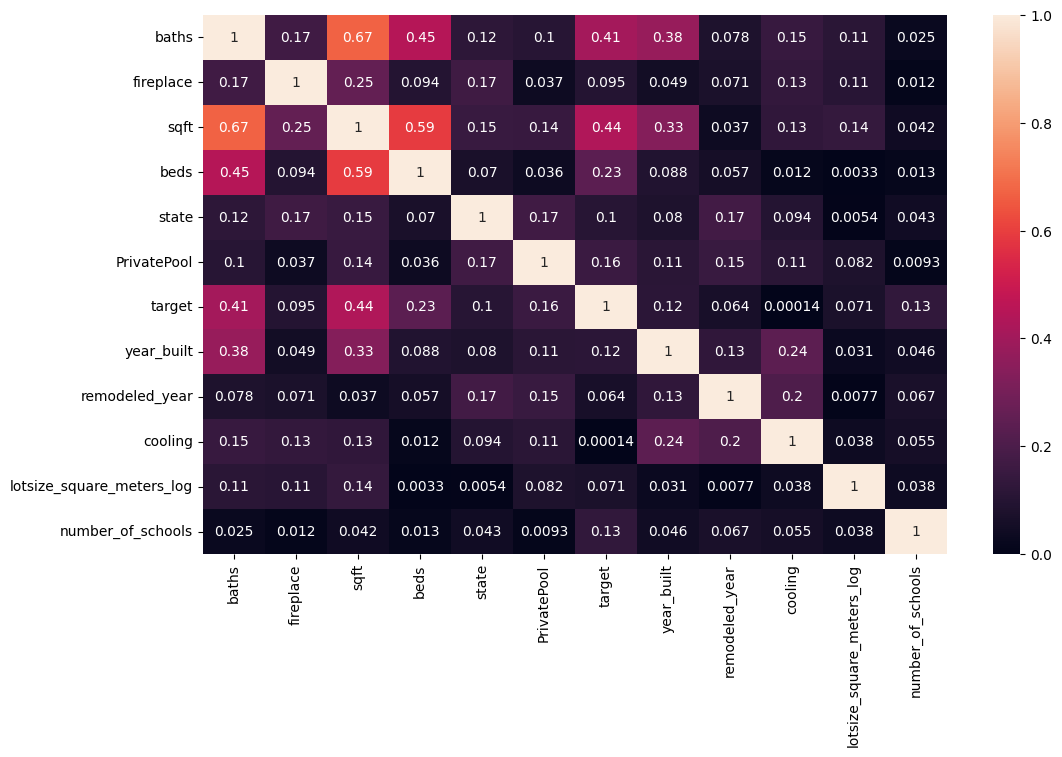

In [136]:
# Список столбцов 
num_cols = ['baths', 'fireplace', 'sqft', 'beds', 'state', 'PrivatePool', 'target', 
            'year_built', 'remodeled_year', 'cooling', 'lotsize_square_meters_log', 'number_of_schools']
# Оценим корреляцию числовых переменных
plt.figure(figsize = (12, 7))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

 - Наблюдаем среднюю связь между признаками количества ванных и спальных комнат от площади дома. Что является закономерным.
 - Наблюдаем слабую связь целевого признака (target) от количества ванных комнта и площади дома

### 4. Моделирование

Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество

In [138]:
# Функиця для вывода результатов
def print_metrics(y_train, y_train_predict, y_test, y_test_predict): 
    print('Рассчитываем MAE')
    print('Train score: {:.0f}$'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Test score: {:.0f}$'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('\n')
    print('Рассчитываем RMSE')
    print('Train score: {:.0f}$'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))))
    print('Test score: {:.0f}$'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))))
    print('\n')
    print('Рассчитываем MAPE')
    print('Train score: {:.0f}%'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict) * 100))
    print('Test score: {:.0f}%'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
    print('\n')
    print('Рассчитываем коэффициент детерминации R2')
    print('Train score: {:.2f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Test score: {:.2f}'.format(metrics.r2_score(y_test, y_test_predict)))

In [147]:
# Разделим данные на обучающую и тестовую выборки.
X = df.drop(['target'], axis = 1)
y = df['target']
#Разделяем выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#shuffle = True,
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80593, 65), (80593,), (20149, 65), (20149,))

### Моделирование

Построим на предобработанных данных модель линейной регрессии

**Модель линейной регрессии:**

Модель линейной регрессии имеет следующий вид:
$$\widehat{y_i}= w_0+\sum_{j=0}^m w_j x_{ij}$$
где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры линейной регрессии
Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 

В качестве функции потерь используем MSE - средний квадрат ошибки.
$$L(\omega) = MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - \widehat{y_i})^2} \Rightarrow min_\omega $$
**Аналитическое решение: метод наименьших квадратов (OLS):**
$$\omega=(X^TX)^{-1}X^Ty$$
В библиотеке sklearn линейная регрессия с поиском параметров по OLS реализована в классе LinearRegression модуля linear_model. 

Методы:
* fit() - подгонка параметров по OLS (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные с помощью OLS коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [143]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Рассчитываем MAE
Train score: 119330$
Test score: 119326$


Рассчитываем RMSE
Train score: 158326$
Test score: 158004$


Рассчитываем MAPE
Train score: 299%
Test score: 112%


Рассчитываем коэффициент детерминации R2
Train score: 0.35
Test score: 0.34


Показатели получились не удовлетворительными


----

Попробуем построить модель Стохастического градиентного спуска. Предварительно нормализуем данные:

In [144]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=24)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Рассчитываем MAE
Train score: 120036$
Test score: 120094$


Рассчитываем RMSE
Train score: 158414$
Test score: 158118$


Рассчитываем MAPE
Train score: 298%
Test score: 113%


Рассчитываем коэффициент детерминации R2
Train score: 0.35
Test score: 0.34


Показатели получились не удовлетворительными

---

**Линейная регрессия с L2-регуляризацией**

L2-регуляризация добавляет к функции ошибки дополнительное слагаемое, которое вносит смещение в обучение модели. Слагаемое - сумма квадратов коэффициентов модели.

$$L(\omega) = MSE + \alpha \sum_{j=1}^{m}{\omega_j^2}$$
$\alpha$ - коэффициент регуляризации, чем он выше, тем большее смещение вносится в модель (тем сильнее штраф за переобучение)
В библиотеке sklearn линейная регрессия с L2-регуляризацией (гребневая регрессия) реализована в классе Ridge модуля linear_model. 

Методы:
* fit() - подгонка параметров по методу координатного спуска - безпроизводный аналов градиентного спуска (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [145]:
y_train_log = np.log(y_train)

In [146]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Рассчитываем MAE
Train score: 96179$
Test score: 97617$


Рассчитываем RMSE
Train score: 139986$
Test score: 142576$


Рассчитываем MAPE
Train score: 209%
Test score: 44%


Рассчитываем коэффициент детерминации R2
Train score: 0.49
Test score: 0.47


Показатели улучшились, но возможность модели предсказать целевой признак составляет менее 50%

Мы получили плохой результата для модели линейной регрессии

---

Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor)

In [162]:
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)
gb.fit(X_train_scaled, y_train_log)
y_train_predict = gb.predict(X_train_scaled)
y_test_predict = gb.predict(X_test_scaled)

#Выводим результирующие метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

      Iter       Train Loss   Remaining Time 


         1           0.4089            1.74m
         2           0.3273            1.57m
         3           0.2779            1.35m
         4           0.2551            1.25m
         5           0.2305            1.17m
         6           0.2147            1.13m
         7           0.2095            1.08m
         8           0.1989            1.06m
         9           0.1918            1.04m
        10           0.1825            1.02m
        20           0.1536           50.21s
        30           0.1402           41.99s
        40           0.1255           34.85s
        50           0.1156           28.83s
        60           0.1089           23.04s
        70           0.1046           17.05s
        80           0.1012           11.32s
        90           0.0966            5.66s
       100           0.0928            0.00s
Train RMSLE: 384297.82.
Valid RMSLE: 381062.72.
Рассчитываем MAE
Train score: 330009$
Test score: 327347$


Рассчитываем RMSE
Train score: 384298

Модель предсказания получилась хуже чем если бы мы просто использовали среднее значение целевого признака, результат не удовлетворительный

---

## 5. Оценка модели


Были обучены модель линейной регрессии, стохастического градиентного спуска, линейная регрессия с L2-регуляризацией 1 бустинговая модель. Все алгоритмы показали неудовлетворительное качество.


Возможные дальнейшие шаги по улучшению:
* feature engineering - попыться сгенерировать новые признаки в данных
* более качестченно произвести очистку (удаление записей) от не информативных значений признаков и пропусков
* попробовать другие варианты кодирования категориальных признаков
* попытаться привести все числовые признаки к нормальному распределению (например, с помощью логарифмирования)
* удалить категориальный признак 'state' (штат), поработаь над признаком этажности
* найти наблюдения, для которых наблюдается высокая ошибка между предсказанием и действительностью и понять, что с ними "не так"
* применить более продвинутые методы машинного обучения xgboost, catboost, нейронные сети